In [2]:
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Merge, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

ModuleNotFoundError: No module named 'keras'

In [4]:
ls

dev_original_related_subject_body_merged.json
org_rel_body_2_categories.pkl
org_rel_body_3_categories.pkl
original_related_body_relevance_pairs.json
original_related_subject_body_relevance_pairs.json
original_related_subject_relevance_pairs.json
siamese_embeddings.pickle
siamese_post_process_dump.pickle
test.csv
train.csv
train_part1_original_related_body_pairs.json
train_part1_original_related_subject_body_merged.json
train_part2_original_related_body_pairs.json
train_part2_original_related_subject_body_merged.json


In [ ]:
import json
dev_file = open('dev_original_related_subject_body_merged.json')
data_dev = json.load(dev_file)

train_part1_file = open('train_part1_original_related_subject_body_merged.json')
data_train_part1 = json.load(train_part1_file)


train_part2_file = open('train_part2_original_related_subject_body_merged.json')
data_train_part2 = json.load(train_part2_file)


In [ ]:
maly_test_przeprowadzam = data_dev + data_train_part1
len(data_dev)

In [ ]:
import csv
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['id', 'qid1', 'qid2', 'question1', 'question2', 'relevance'])
    
    for idx, elem in enumerate(data_dev + data_train_part1):
        writer.writerow([idx, idx*2+1, idx*2+2, elem['original_question'], elem['related_question'], elem['relevance']])
    
with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['id', 'qid1', 'qid2', 'question1', 'question2', 'relevance'])
    
    for idx, elem in enumerate(data_train_part2):
        writer.writerow([idx, idx*2+1, idx*2+2, elem['original_question'], elem['related_question'], elem['relevance']])
    
    

In [ ]:
import pandas as pd
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

In [1]:
pwd

'/Users/jacek/projects/cqa-sem-eval/subtask_B'

In [3]:
TRAIN_CSV = './data/train.csv'
TEST_CSV = './data/test.csv'
EMBEDDING_FILE = '../GoogleNews-vectors-negative300.bin.gz'

In [4]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

stops = set(stopwords.words('english'))

def text_to_word_list(text):
    ''' Pre process and convert texts to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text

vocabulary = dict()
inverse_vocabulary = ['<unk>']

print("Started loading google vectors...")
# '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)

print("Finished loading google vectors...")

questions_cols = ['question1', 'question2']

# Iterate over the questions only of both training and test datasets
for dataset in [train_df, test_df]:
    for index, row in dataset.iterrows():
        


        # Iterate through the text of both questions of the row
        for question in questions_cols:
            
            print(question)
            
            q2n = []  # q2n -> question numbers representation
            for word in text_to_word_list(row[question]):
                
                print(word + "\n")

                # Check for unwanted words
                if word in stops and word not in word2vec.vocab:
                    continue

                if word not in vocabulary:
                    vocabulary[word] = len(inverse_vocabulary)
                    q2n.append(len(inverse_vocabulary))
                    inverse_vocabulary.append(word)
                else:
                    q2n.append(vocabulary[word])

            # Replace questions as word to question as number representation
            dataset.set_value(index, question, q2n)
            
embedding_dim = 300
embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
embeddings[0] = 0  # So that the padding will be ignored

# Build the embedding matrix
for word, index in vocabulary.items():
    if word in word2vec.vocab:
        embeddings[index] = word2vec.word_vec(word)

del word2vec

Started loading google vectors...
Finished loading google vectors...
question1
good

bank

which

is

a

good

bank

as

per

your

experience

in

doha

question2
best

bank

hi

guys;

i

need

to

open

a

new

bank

accoount

which

is

the

best

bank

in

qatar

i

assume

all

of

them

will

roughly

be

the

same;

but

stll

which

has

a

slight

edge

money

transfer;

benifits

etc

thanks

!

!

!

question1
good

bank

which

is

a

good

bank

as

per

your

experience

in

doha

question2
what

is

the

best

bank

to

open

an

account

seems

like

all

the

banks

need

the

salary

to

be

credited

to

their

accounts

where

i

came

from

that

was

not

a

necessity

so

it

sort

of

limits

my

choices

can

anyone

recommend

me

a

bank

that

has

good

interest

rates

on

loans

and

credit

cards

so

far

i

am

considering

doha

bank

because

of

the

lulu

card

is

it

worth

it

:

question1
good

bank

which

is

a

good

bank

as

per

your

ex


question1
what

are

the

tourist

places

in

qatar

im

likely

to

travel

in

the

month

of

june

just

wanna

know

some

good

places

to

visit

question2
what

to

do

on

eid

holidays

any

suggestions

on

what

are

the

happenings

in

qatar

on

holidays

something

new

and

exciting

suggestions

please

question1
what

are

the

tourist

places

in

qatar

im

likely

to

travel

in

the

month

of

june

just

wanna

know

some

good

places

to

visit

question2
best

snorkeling

place

in

qatar

where

in

qatar

is

the

best

place

for

snorkeling

i

am

planning

to

go

out

next

friday

but

do

not

know

where

to

go

question1
what

are

the

tourist

places

in

qatar

im

likely

to

travel

in

the

month

of

june

just

wanna

know

some

good

places

to

visit

question2
what

to

do

with

teenagers

in

doha

can

you

give

me

some

nice

places

to

go;

or;

fun

things

to

do

in

doha

for

children

17

-

18

years

old

where

can


any

idea;

please

share

with

me

please

question2
qp

offer

negotiation

hi

all;

i

have

finally

received

the

official

offer

from

qp

and

i

think

i

am

being

lowballed

the

offer

is

qr23;000

+

14;200

housing

and

school

and

benefits

they

put

me

in

grade

16

i

do

not

know

anything

about

these

grades

can

anyone

enlight

me

and

tell

me

also

how

much

i

can

negotiate

i

read

some

mixed

discussions

about

the

leeway

i

have

for

negotiation

i

was

expecting

qr35;000

basic;

realistic

thx

in

advance

question1
qp

offer

i

had

an

interview

with

department

head

and

lead

people

not

hr

at

qp

for

the

grade

-

13

post

and

they

said

they

will

inform

me

the

next

procedure

like

medical

chekups

etc

does

anybody

have

the

idea

how

much

it

will

take

to

complete

the

procedure

and

when

can

i

get

the

offer

letter

and

please

do

let

me

know

what

will

be

the

approximate

salary


much

it

will

take

to

complete

the

procedure

and

when

can

i

get

the

offer

letter

and

please

do

let

me

know

what

will

be

the

approximate

salary

and

other

allowances

if

anybody

have

any

idea;

please

share

with

me

please

question2
qp

vs

aramco

anybody

here

who

can

give

advice

about

working

for

qp

vs

aramco

what

are

the

main

differences;

pros

cons

between

the

two

i

am

in

final

talks

with

both

companies;

no

offers

yet

but

looks

promising

background

info

:

finance

manager;

40

years;

divorced;

currently

with

bp;

uk

national

question1
which

is

the

best

hospital

for

baby

vaccinations

our

baby

is

scheduled

for

his

six

month

vaccination

and

we

we

wondering

where

to

take

him

some

people

say

it

depends

on

the

freshness

of

the

vaccine

are

all

common

vaccinations

available

everywhere

price

is

not

an

issue

as

long

as

our

boy

is

safe;

preferably

afternoon

c


i

am

coming

in

2

weeks

to

doha

and

i

was

wondering

how

the

weather

in

december

should

i

bring

winter

clothes

jacket

coat

wool

etc

i

can

see

in

the

forcasts

that

it

can

go

down

to

10deg

sometimes

but

this

does

not

mean

much

since

there

a

lot

of

factors

for

example

10deg

celsius

is

ok

in

boston

but

if

you

go

to

washington

you

are

gonna

freeze

in

10deg

c

ty

question2
how

cold

is

doha

during

winter

i

am

just

curious

how

cold

is

doha

during

winter

question1
can

some

1

give

me

cats

or

kittens

hi

and

hello

i

need

cats

or

kittens

if

you

have

because

my

cat

deid

yeterday

:

but

you

can

help

me

if

you

have

cats

i

will

buy

but

the

priceshould

be

between

100

-

150

you

can

help

me

:

if

you

can

call

me

my

number

6983357

hotmail

salmankhan

tweety

hotmail

com

question2
what

to

call

my

cat

i

recently

came

home

with

a

puddy

tat

from

qaws




is

there

a

carseat

law

in

qatar

is

there

a

selection

of

carseats

to

buy

in

doha

question1
child

safety

seats

salaam

-

hello

can

anyone

tell

me

what

are

the

laws

about

car

seats

for

children

in

qatar

i

am

sure

i

can

buy

them

there

but

also

wondering

if

i

should

bring

what

i

have

or

buy

there

thanks

!

question2
it

is

very

dangerous

!

!

!

!

!

!

!

!

!

!

!

!

!

just

a

question

:

why

do

not

qatari

people

buckle

up

their

children

in

the

car

i

even

saw

a

lot

of

babies

on

their

mother

laps

in

the

front

seat;

this

is

too

dangerous

!

!

!

please

do

it

for

the

children

!

!

!

!

!

!

question1
child

safety

seats

salaam

-

hello

can

anyone

tell

me

what

are

the

laws

about

car

seats

for

children

in

qatar

i

am

sure

i

can

buy

them

there

but

also

wondering

if

i

should

bring

what

i

have

or

buy

there

thanks

!

question2
car

seats

what

cars

plants

:

both

outdoor

ones

for

the

garden

and

indoor

ones

in

pots

if

possible

please

give

directions

to

the

shop

market

thanks

!

question2
plants

photography

can

anyone

tell

me

where

i

can

buy

some

indoor

plants;

besides

the

supermarket

are

there

any

nurseries

in

doha

also;

are

there

any

photography

competitions

in

doha

thanks

in

advance

question1
best

place

to

buy

plants

please

recommend

a

good

place

to

buy

plants

:

both

outdoor

ones

for

the

garden

and

indoor

ones

in

pots

if

possible

please

give

directions

to

the

shop

market

thanks

!

question2
nursery

for

plants

hi

!

does

anyone

know

of

any

nurseries

for

plants

in

doha

what

kind

of

plants

do

you

get

there

how

feasible

is

it

to

have

a

garden

in

doha

considering

the

extreme

climate

any

body

who

has

orchids

at

home

please

lemme

know

thanks

in

advance

someonenew

question1
best

place

to

buy

pla

does

anyone

know

any

activities

that

my

children

of

primary

age

could

do

so

they

still

meet

people

clubs;

activities;

extra

classes

etc

question2
special

needs

of

children

many

of

our

childrren

are

born

with

some

handicaps;

which

require

special

educational

skills;

i

had

posted

many

classifieds

for

teaching

these

children

but

the

response

is

zero;

it

seems

parents

are

reluctant

to

give

the

children

the

window

to

life

or

their

are

zillion

schools

run

in

qatar

for

which

we

donot

have

any

knowledge

about

can

smebody

help

to

locate

these

schools

parul

desai

question1
does

anyone

home

school

their

children

we

are

struggling

to

find

a

school

place

and

are

thinking

of

home

schooling

does

anyone

know

anyone

who

does

this

in

doha

does

anyone

know

any

activities

that

my

children

of

primary

age

could

do

so

they

still

meet

people

clubs;

activities;

extra

cl

she

wants

to

be

familiarized

first

with

labor

code

of

qatar

as

per

requisite

in

the

human

resources

services

can

some

body

help

me

to

secure

a

latest

copy

of

labor

code

which

is

english

translation

thanks

question2
why

is

polygamy

bigamy

a

crime

in

the

west

why

is

polygamy

bigamy

is

considered

a

crime

in

the

west

crime

in

what

sense

what

if

the

wife

agrees

and

is

cheating

on

wife

having

a

permanent

girlfriend

besides

her

considered

an

equally

serious

crime

and

why

why

is

polygamy

bigamy

prohibited;

while

prostitution

and

same

sex

marriage

are

being

legalized

it

is

said

that

even

in

islamic

countries;

bigamy

is

limited;

so

why

is

the

west

so

scared

about

it

question1
latest

qatar

labor

code

my

wife

is

planning

to

come

here

in

qatar

she

wants

to

be

familiarized

first

with

labor

code

of

qatar

as

per

requisite

in

the

human

resources

services




conservatively;

or

are

those

not

wearing

them

being

disrespectful

and

simply

tolerated

question1
direction

to

lu

lu

any

one

tell

me

how

to

drive

to

lu

lu

from

tv

ra

question2
lulu

hypermarket

hi

i

am

a

new

user;

my

first

post

i

will

be

visiting

doha

for

the

first

time

for

a

job

interview

in

a

couple

of

weeks

and

i

have

looked

on

a

couple

of

maps

to

to

no

avail

can

any

one

please

direct

me

to

the

lulu

hypermarket

in

which

area

is

this

located

and

decent

large

land

marks

so

i

cross

refer

back

to

on

my

maps

thanks

in

advance

question1
direction

to

lu

lu

any

one

tell

me

how

to

drive

to

lu

lu

from

tv

ra

question2
please

advise

where

i

repair

my

daughter

ipad

ear

ql

friends;

please

advise

where

we

will

repaire

ipad;

ilife

brand

this

is

new

one

that

we

bought

from

lulu

recently

but

the

screen

comes

in

reverse

direction

so

my

daughter


can

anyone

please

advise

on

where

to

go

which

area

of

doha

question1
sandy

beaches

we

now

feel

ready

to

explore

qatar

and

was

wondering

if

anyone

can

suggest

a

sandy

beach

that

suitable

for

young

children

directions

would

be

appreciated

as

we

have

not

been

anywhere

outside

doha

thanks

question2
could

you

suggest

the

best

holiday

destination

in

the

world

holiday

destinations

and

your

experience

question1
sandy

beaches

we

now

feel

ready

to

explore

qatar

and

was

wondering

if

anyone

can

suggest

a

sandy

beach

that

suitable

for

young

children

directions

would

be

appreciated

as

we

have

not

been

anywhere

outside

doha

thanks

question2
best

snorkeling

place

in

qatar

where

in

qatar

is

the

best

place

for

snorkeling

i

am

planning

to

go

out

next

friday

but

do

not

know

where

to

go

question1
sandy

beaches

we

now

feel

ready

to

explore

qatar

and

was

wondering

if



question1
ql

confessions

thread

all

you

sinners

come

and

confess

on

this

thread

or

go

and

post

on

i

am

not

a

stupid

qler

thread

my

confession

-

i

love

cookies

more

than

the

chocolates

and

my

parents

do

not

know

about

it

question2
women

drivers

!

!

!

^

^

x

-

what

is

the

one

thing

you

simply

hate

about

the

way

women

drive

on

the

streets

if

i

were

to

list

it

out;the

list

would

be

endless

in

spite

of

being

a

female

driver

myself;i

just

hate

some

of

the

antics

they

show

on

the

streets

!

i

guess

changing

lanes

without

signals

tops

my

hate

-

list

!

grrrrr

!

x

-

question1
ql

confessions

thread

all

you

sinners

come

and

confess

on

this

thread

or

go

and

post

on

i

am

not

a

stupid

qler

thread

my

confession

-

i

love

cookies

more

than

the

chocolates

and

my

parents

do

not

know

about

it

question2
confession

woman

:

father;

i

confess

every

tim

address

in

between;

hence

i

am

unable

to

ask

him

direct

cheers;

don

question1
what

agencies

we

can

hire

a

car

and

a

driver

i

am

loooking

into

hiring

a

car

with

a

driver;

have

heard

some

agencies

here

in

doha

do

it

any

tips

many

thanks

question2
buying

car

without

driving

license

hi

folks;is

it

possible

to

buy

a

car

and

resister

it

in

my

name

without

having

a

driving

license

question1
what

agencies

we

can

hire

a

car

and

a

driver

i

am

loooking

into

hiring

a

car

with

a

driver;

have

heard

some

agencies

here

in

doha

do

it

any

tips

many

thanks

question2
visa

cancellation

without

passport

can

my

sponsor

cancel

my

visa

even

without

my

passport

thank

you

guys

question1
what

agencies

we

can

hire

a

car

and

a

driver

i

am

loooking

into

hiring

a

car

with

a

driver;

have

heard

some

agencies

here

in

doha

do

it

any

tips

many

thanks

question2
shipments



finnance

controller

!

did

am

able

to

get

on

arrival

visa

!

and

how

can

i

proceed

how

much

i

have

to

pay

and

how

long

i

can

be

there

with

this

feslity

!

plz

help

me

its

very

urgent

question1
how

much

it

will

cost

for

a

visit

visa

how

much

it

will

cost

for

a

visit

visa

question2
visit

visa

work

visa

hi

guys;

do

u

any

have

idea

regarding

the

procedure

of

visas

over

there

in

qatar

if

anybody

comes

in

visit

visa

and

search

for

jobs

over

there

if

any

find

the

job;

in

that

circumstance

how

the

process

will

be

to

change

the

visit

visa

to

working

visa

is

it

difficult

and

time

consuming

how

have

to

process

for

the

change

of

visa

kindly

suggest

anybody

take

care

question1
how

much

it

will

cost

for

a

visit

visa

how

much

it

will

cost

for

a

visit

visa

question2
visit

visa

for

pakistanis

kindly

someone

tell

me;

specially

if

there

is

someone



october

question1
car

taking

to

india

i

wish

to

take

my

car

toyota

corolla

2003

to

india;

is

it

expensive

can

any

body

explain

what

are

the

procedures

please

question2
shiping

car

from

qatar

to

india

i

am

using

nissan

altima

for

past

two

years

i

am

planning

to

settle

back

india

is

it

possible

to

ship

my

car

to

india

is

it

advisable

any

one

did

earlier

question1
car

taking

to

india

i

wish

to

take

my

car

toyota

corolla

2003

to

india;

is

it

expensive

can

any

body

explain

what

are

the

procedures

please

question2
shipments

to

qatar

hello

all;

we

are

moving

to

qatar

in

august

need

advice

on

sending

2

separate

household

goods

shipments

any

comments

on

that

what

are

the

documents

required

to

send

a

shipment;

what

is

required

to

receive

a

shipment

any

information

on

household

shipments

and

regulations

would

be

appreciated

thanks;

fitri

question1
car



plate;

he

started

eating

right

away

logan;

wait

until

we

say

our

prayer;

his

mother

reminded

him

i

do

not

have

to;

the

little

boy

replied

of

course

you

do;

his

mother

insisted;

we

say

a

prayer

before

eating

at

our

house

that

at

our

house;

logan

explained;

but

this

is

grandma

house

and

she

knows

how

to

cook

question2
islam

and

sports

a

question

from

non

-

muslim

i

have

been

following

up

the

world

championship

in

artistic

gymnastics;

and

then

there

was

a

picture

of

a

qatari

gymnast

aljazy

al

-

habshi

http

:

www

minkusimages

de

img

mi077

3d592d304d2ce26b96bc2260f69e2de1

52865

jpg

just

would

like

to

understand

how

does

it

comply

with

islamic

rules

of

woman

covering

body

and

hair

or

is

this

girl

violating

the

religious

rules

would

like

to

get

an

answer

from

our

fellow

qataris;

please

question1
pray

before

eating

everyone

was

seated

around

the

ta


have

a

great

time

as

always

all

the

best

god

bless

signing

out

question2
re

-

entry

visa

-

umrah

hi

friends

i

want

to

know

what

is

the

procedure

for

re

-

entry

visa

to

come

back

qatar

after

umrah

can

i

get

it

only

after

saudi

visa

is

ready

or

even

before

thanks

question1
i

am

done

with

ql

will

miss

you

all

have

a

great

time

as

always

all

the

best

god

bless

signing

out

question2
where

do

you

get

your

hair

done

where

do

you

get

your

haircut

boys

kindly

advise

where

would

be

your

best

barber

in

town

thanks

question1
i

am

done

with

ql

will

miss

you

all

have

a

great

time

as

always

all

the

best

god

bless

signing

out

question2
call

for

strike

!

!

i

am

boycotting

ql

for

a

week

anyone

wanna

join

me

if

you

delete

this

you

are

one

insecure

insane

kid

!

!

question1
i

am

done

with

ql

will

miss

you

all

have

a

great

time

as

always

all




a

balut

i

cannot

love

a

filipina

is

there

any

relation

between

a

balut

and

love

should

i

eat

one

or

kick

her

question1
dogs

on

vacation

does

anyone

know

if

there

is

a

dog

kennel

hotel

in

qatar;

where

we

can

have

someone

to

look

after

our

dogs;

when

we

go

on

vacation

best

regards

question2
tasweeq

hello

fellow

ql

ers;

does

anyone

have

a

number

for

a

company

called

tasweeq

aand

yes;

i

did

try

180;

but

as

we

all

know

question1
dogs

on

vacation

does

anyone

know

if

there

is

a

dog

kennel

hotel

in

qatar;

where

we

can

have

someone

to

look

after

our

dogs;

when

we

go

on

vacation

best

regards

question2
are

there

any

dangerous

wild

animals

in

qatar

question1
dogs

on

vacation

does

anyone

know

if

there

is

a

dog

kennel

hotel

in

qatar;

where

we

can

have

someone

to

look

after

our

dogs;

when

we

go

on

vacation

best

regards

question2
minimum

wage

for



or

sura

etc

if

you

want

but

you

must

expand

upon

them

with

your

own

thoughts

question2
tattoo

in

islam

according

to

islam

are

we

muslims

allowed

to

get

tattoo

done

ive

done

a

lil

bit

of

research

and

asked

loads

of

people

but

couldnt

find

a

strong

proof

or

a

strong

point

mostly

wot

i

got

was

50

-

50

wot

do

u

have

to

say

about

this

question1
nursing

license

requirements

i

am

a

male

nurse;passed

qatar

prometric

exam

and

my

dataflow

is

on

process

in

sch

i

got

an

offer

from

an

employer;but

i

am

having

doubt

that

whether

i

can

start

my

work

or

not

what

are

all

the

next

steps

i

have

to

do

if

anyone

can

clarify

my

doubt;it

will

be

very

helpfull

for

me

thank

you

in

advance

!

question2
prometric

exam

for

nurses

can

anyone

help

me

in

giving

some

information

regarding

qatar

prometric

exam

for

nurses

and

what

the

requirement

to

sit

for

the

e

the

letter

p

thus

in

its

absence;

people

here

would

normally

pronounce

p

as

b

whenever

they

encounter

words

that

have

letter

p;

for

instance

words

such

as

pakistan

toothpaste;

hypertext;

or

anything

that

has

p

on

it

sounds

funny

huh

but

you

ll

get

used

to

it

i

feel

a

bit

sorry

for

superman

and

spiderman;

lucky

batman

though

heeheeehe

question1
i

just

lost

my

wallet

in

a

shopping

center

i

just

lost

my

wallet;

somebody

stole

it

in

my

back

pocket

is

there

any

way

i

can

retrieve

all

my

id

and

license

nevermind

about

the

money

all

i

care

about

are

my

id

:

i

really

thought

those

kind

of

people

does

not

exist

here

in

doha

:

question2
where

do

qataris

hangout

anybody

have

any

clue

where

the

qataris

hangout

like

places

where

they

sit

around;

chit

chat;

talk

about

anything

under

the

sun

any

idea

really

curious

as

u

seldom

see

them

wondering

a

doha

!

post

some

websites

for

used

cars

and

brand

new

cars

what

is

the

most

reliable

agent

in

doha

simply

what

car

to

buy

question1
buying

a

car

hi;

i

am

planning

to

buy

a

car;

which

is

better

honda

civic

or

hyundai

santa

fe;

both

2011

model

just

new

here

in

qatar

could

you

pls

give

some

feedback

reviews

question2
when

is

the

best

time

to

buy

a

car

dear

fellow

ql

;

i

am

planning

to

buy

a

car

but

so

far

have

been

intimidated

with

the

escalating

car

prices

in

almost

all

dealerships

and

agencies

i

am

now

revising

my

plans

to

wait

for

promotion

or

season

where

the

price

is

discounted

can

anyone

help

me

when

will

be

the

best

time

to

buy

a

car

further

clarifications

would

be;

would

it

be

best

to

buy

during

ramadan;

last

quarter

of

the

year;

etc

thanks

in

advance

question1
buying

a

car

hi;

i

am

planning

to

buy

a

car;

which

is

better



me

that

they

dont

issue

it

anymore

at

the

airport

office

what

about

the

immigration

office

have

they

stopped

it

there

too

question2
umrah

visa

for

qatar

visitors

does

anybody

know

when

saudi

embassy

will

open

umrah

visa

for

visitors

this

is

very

urgent

please

reply

if

anybody

has

information

about

this

thanks

in

advance

question1
no

more

visit

visa

can

someone

confirm

if

this

is

true

a

friend

of

mine

just

told

me

that

they

are

no

longer

issuing

visit

visas

to

anyone

two

people

have

already

mentioned

to

me

that

they

dont

issue

it

anymore

at

the

airport

office

what

about

the

immigration

office

have

they

stopped

it

there

too

question2
maximum

period

of

a

visit

visa

i

am

currently

in

doha

on

a

3

month

visit

visa

anybody

can

please

tell

me;

whether

i

can

extend

this

futher

more;

maximum

of

how

many

months

question1
no

more

visit

visa

can

someo

like

last

two

3

am

nights

have

been

working

continously

for

three

days

now

i

feel

like

passing

out

there

a

board

meeting

day

after

and

work

is

only

half

finished

is

it

bye

bye

doha

time

i

have

never

been

so

scared

in

my

life

give

me

some

sympathy

please

excess

qling

has

done

this

to

me

i

wish

i

had

known

better

and

had

not

kept

backlogs

question1
qling

after

working

hours

how

many

of

you

logon

to

ql

after

your

working

hours

question2
anyone

wanna

talk

about

anything

work

-

related

i

wonder

why

ql

never

talk

about

any

experiences

or

what

happened

today

at

work

or

nobody

working

here

in

ql

other

than

me

xp

question1
qling

after

working

hours

how

many

of

you

logon

to

ql

after

your

working

hours

question2
what

are

the

common

diseases

in

qatar

i

noticed

that

there

some

common

diseases

with

a

lot

of

ppl

here

in

qatar;

especially

with

expa

by

his

boss;

now

he

is

just

sitting

infront

of

boss

and

thinking

how

many

lol

i

missed

till

now

bechar

pappu;

pappu

nach

nahi

sakta

http

:

i46

tinypic

com

of69hz

jpg

question1
where

is

pajju

i

do

not

use

much

qatar

living;

but

still

i

visit

daily

;

just

reading

forums;

comments

and

some

time

i

comment

also

always

tried

not

to

miss

comment

of

pajju;

britexpat

cox

the

one

was

funny

and

other

is

too

much

informative

and

well

mannered

but

now

the

question

is

that

where

is

pajju

long

time

i

didnt

saw

any

comment

of

him

is

he

alright

question2
who

is

the

best

hijacker

here

in

ql

please

comment

:

question1
where

is

pajju

i

do

not

use

much

qatar

living;

but

still

i

visit

daily

;

just

reading

forums;

comments

and

some

time

i

comment

also

always

tried

not

to

miss

comment

of

pajju;

britexpat

cox

the

one

was

funny

and

other

is

too

much

infor


times

that

the

water

after

boiling

has

a

certain

smell

like

disinfector

do

they

control

the

quantity

of

chemicals

in

water

treatment

is

it

ok

to

drink

the

tap

water

after

boiling

question1
massage

oil

where

i

can

buy

good

oil

for

massage

question2
massage

oil

is

there

any

place

i

can

find

scented

massage

oils

in

qatar

question1
massage

oil

where

i

can

buy

good

oil

for

massage

question2
philipino

massage

center

hi;can

any

one

tell

me

a

place

where

i

can

have

a

good

massage

drom

philipinies

yesterday

i

had

a

massage

in

bio

-

bil

they

charged

me

300qr

for

01

hour

bt

it

is

totally

waste

pls

advice

me

if

theres

any

philipinos

question1
massage

oil

where

i

can

buy

good

oil

for

massage

question2
best

place

for

massage

tell

me;

where

is

the

best

place

to

go

for

a

massage

mind

you;

i

do

not

want

to

spend

1000qr

for

it

guys;

please

do

not

come

2

3

months

visa

what

is

the

procedure

pls

inform

question2
multiple

entry

visit

visa

is

there

any

option

of

multiple

entry

visit

visa

for

qatar

someone

is

saying;

there

is

only

single

entry

visa

option

also;

where

can

i

find

the

list

of

required

documents

as

i

could

not

see

any

such

document

in

moi

gov

qa

website

question1
how

to

extend

the

visit

visa

after

6

months

and

how

long

period

want

to

extend

the

visit

visa

what

are

the

procedures

and

how

long

i

get

the

extension

thanks

for

the

answers

question2
maximum

period

of

a

visit

visa

i

am

currently

in

doha

on

a

3

month

visit

visa

anybody

can

please

tell

me;

whether

i

can

extend

this

futher

more;

maximum

of

how

many

months

question1
how

to

extend

the

visit

visa

after

6

months

and

how

long

period

want

to

extend

the

visit

visa

what

are

the

procedures

and

how

long

i

get

the

extension

th


his

house

there

can

you

give

us

advice

and

the

steps

to

take

for

getting

visa

and

requirements

for

marriage

there

in

qatar

it

will

be

greatly

appreciated

thanks

in

advance

question2
via

hongkong

before

coming

to

doha

tatanong

lang

po

kung

sino

man

sa

mga

kabayan

natin

ang

nag

hongkong

muna

nag

tour

man

o

hindi

tapos

pumunta

ng

qatar

ano

ba

ang

mga

tinatanong

na

mga

reequirements

ng

hongkong

immigration

kung

papunta

ka

dito

sa

qatar

question1
how

can

my

boyfriend

get

me

and

our

baby

son

a

visit

visa

there

how

can

my

boyfriend

who

currently

works

for

a

government

office

there

get

me

and

our

baby

a

visit

visa

how

long

can

we

stay

there

in

doha

and

can

we

also

get

married

there

as

well

can

we

stay

together

in

his

house

there

can

you

give

us

advice

and

the

steps

to

take

for

getting

visa

and

requirements

for

marriage

there

in

qatar

it

w


been

quoted

1000

to

have

them

flown

over

is

it

worth

the

hassle

of

customs

or

should

i

buy

new

how

do

prices

compare

uk

next

with

qatar

next

question2
gift

vouchers

for

doha

hello;

i

live

in

england

and

my

sister

is

in

doha

is

it

possible

for

me

to

purchase

gift

vouchers

for

my

sister

to

use

in

department

stores

in

doha

i

would

like

to

pay

online

and

then

email

my

sister

a

reference

does

anybody

know

of

any

shops

that

allow

this

question1
is

it

cheaper

to

buy

new

clothes

in

qatar

than

pay

to

transport

them

over

from

the

uk

i

begin

employment

in

qatar

aug

09

and

have

just

been

quoted

1000

to

have

them

flown

over

is

it

worth

the

hassle

of

customs

or

should

i

buy

new

how

do

prices

compare

uk

next

with

qatar

next

question2
qatari

wedding

we

have

been

invited

to

a

qatari

wedding

this

thursday;

and

apart

from

not

knowing

anyone

as

m


trade

it;

where

is

the

best

trading

company

as

well

as

to

where

to

sell

it

question2
expats

buying

property

in

qatar

have

any

expats

on

this

forum

either

bought

property

in

qatar;

or

considered

buying

and

then

rejected

-

i

e

zig

zag

towers;

the

pearl

etc

i

am

trying

to

evaluate

whether

or

not

this

would

be

a

good

investment

what

do

you

think

are

the

potential

risks

and

upsides

if

you

have

bought;

what

was

your

experience

of

the

process

and

in

hindsight;

was

it

a

good

decision

regards

question1
anyone

knows

where

the

best

to

sell

or

trade

cars

here

in

doha

i

was

thinking

of

trading

or

selling

my

car

in

case

i

want

to

trade

it;

where

is

the

best

trading

company

as

well

as

to

where

to

sell

it

question2
business

opportunities

in

qatar

hi

every

one;please

help

me

put

in

finding

some

business

oppurtunities

in

qatar

jus

let

me

know

what

b

wish

me

luck

!

take

care

question1
who

is

the

best

hijacker

here

in

ql

please

comment

:

question2
lucky

to

have

this

kind

of

wife

http

:

www

youtube

com

watch

v

=

auw9vmwfxzo

feature

=

player

embedded

question1
who

is

the

best

hijacker

here

in

ql

please

comment

:

question2
boys

girls

lets

start

posting

ur

good

idea

regarding

each

other

q1

suppose

if

u

get

a

chance

to

be

woman

if

u

r

man

or

vice

versa

then

what

bad

thing

u

will

remove

from

each

other

itself

my

question

is

that

if

u

become

man

from

women

then

what

will

u

remove

bad

thing

regading

women

from

ur

habit

as

a

being

man

or

vice

versa

impossible

:

it

self

says

i

m

possible

!

gotcha

question1
who

is

the

best

hijacker

here

in

ql

please

comment

:

question2
dirty

trick

indeed

!

did

you

guys

see

the

qatarchat

blogosphere

http

:

www

qatarchat

8m

com

rich

text

7

html

it

is

each


up

listening

to

sad

songs

which

breakup

song

do

you

like

and

why

how

did

you

overcome

your

split

with

you

loved

one

guinness

is

my

best

pal

at

the

moment

and

keeps

me

company

when

i

am

not

working

sorry

i

know

it

is

the

weekend

and

we

should

all

be

in

a

jolly

mood

question1
bye

bye

time

almost

it

4

:

30

pm;

almost

time

for

me

to

go

home

it

had

been

an

interesting

ql

day

today

hope

to

see

everyone

again

tomorrow;

hopefully;

there

not

much

traffic

so

travelling

home

should

be

a

breeze

good

evening

to

y

all

!

question2
please

help

-

is

this

salary

offer

fair

hi

i

have

just

been

offered

a

job

grade

6

as

a

recruitment

hr

personel

basic

:

qr5400;

housing

:

qr2500;transport

allowance

:

qr600

per

month

i

have

only

10

days

to

take

up

or

reject

this

offer

is

there

room

for

negotiation

with

companies

in

qatar

my

future

employer

should



an

employer

i

am

an

expat

western

;

only

english

speaking;

currently

a

resident

of

qatar

family

sponsorship

;

with

a

degree

i

have

been

persuing

employment

opportunties

at

qa

commercial

can

anyone

provide

input

on

qa

reputation

as

an

employer

does

anyone

know

anything

of

their

salary

ranges

question1
qatar

airways

cabin

crew

if

i

wanted

to

apply

for

qatar

airways

as

cabin

crew;

would

they

let

me

sponsor

my

son

question2
interview

with

qr

dear

all;

i

had

an

interview

with

qr

last

week

they

said

they

would

get

back

to

me

soon

-

how

long

is

soon

in

a

qatari

context

question1
for

the

ladies

please

help

me

i

am

looking

to

buy

a

wet

grinder

in

doha

can

anyone

who

has

purchased

one

from

here

give

me

the

make

and

model

no

something

small

for

the

table

-

top

and

with

no

other

attachments

as

i

have

everything

else

question2
handbags

-

serious

qu


buddy

pajju

is

in

need

of

a

manicure

see

attached

where

the

best

place

question2
best

hair

relaxing

done

in

qatar

hi

all;

i

just

wanted

to

know

where

can

i

get

the

best

hair

relaxing

treatment

in

qatar

i

have

extremely

frizzy

hair

and

i

need

to

get

it

fixed

asap

but

with

the

best

i

have

generally

seen

that

ladies

who

do

hair

relaxing

or

hair

rebounding

jobs

here;

their

hair

looks

like

dry

grass

i

need

someone

who

can

make

it

look

extremely

natural;

as

if

i

was

born

with

it

ladies

please

help

!

!

!

question1
where

the

best

manicure

my

buddy

pajju

is

in

need

of

a

manicure

see

attached

where

the

best

place

question2
guys

of

ql;

spa

day

or

gym

women

often

think

of

the

spa

day

as

a

prefect

getaway

to

wrap

themselves

in

calmness;

and

spend

quality

time

off

and

away

from

the

mundane

daily

routine

i

e

from

him

and

the

kids

lol

what

a

before

embacking

on

the

journey

to

make

it

a

smooth

one

and

also

like

hour

many

hours

will

the

journey

be;

it

is

cost

effective

comapre

to

going

by

air;

for

family

of

3

thanks

question1
another

question

about

sponsorship

hypothetically

speaking

:

if

a

wife

that

arrived

on

husband

sponsorship

gets

a

job;

and

wants

to

leave

that

job

for

another

better

paying

job;

can

she

do

it

without

any

restricions

question2
tricky

question

!

guys

i

have

a

question;

suppose

that

i

decided

to

buy

one

of

the

apartments

in

one

of

the

freehold

projects

such

as

the

pearl

or

the

west

bay;

what

will

happen

to

my

sponsorship

status;

will

i

remain

under

the

sponsorship

of

my

company

or

this

will

change

and

if

it

changed

and

i

was

granted

another

type

of

residence

permit;

will

i

be

entitled

to

work

in

another

place

in

qatar

or

not

question1
another

question

about


u

guys

socialise

in

qatar

how

to

meet

people

and

make

friends

except

internet

which

places

are

appropriate

for

socialise

write

your

experiences

:

question1
souq

waqif

timings

what

are

the

souq

timings

for

this

week

and

eid

thank

you

question2
trips

to

zikrit

film

city

dear

ql

member;

have

anybody

been

there

before

please

suggest

me

that

what

are

the

attractions

over

there

can

i

go

there

without

4x4

your

opinion

highly

appreciated

thanks

question1
souq

waqif

timings

what

are

the

souq

timings

for

this

week

and

eid

thank

you

question2
qatar

ghosts

and

hauntings

what

are

the

most

haunted

places

in

qatar

what

are

the

most

popular

ghost

stories

doing

the

rounds

i

heard

that

there

is

a

ghost

couple

aroung

simaisma

bridge

on

the

way

to

al

khor

there

is

also

a

haunted

house

somewhere

outside

doha

question1
employment

band

help

!

!

who

is

imposing

a

2




home

just

write

here

you

name

nd

phone

number

so

i

can

contact

you

cats

helper

question1
what

to

call

my

cat

i

recently

came

home

with

a

puddy

tat

from

qaws

and

cant

think

of

a

name

its

a

male

can

someone

tell

me

what

cat

is

in

arabic

please

question2
my

cat

always

hang

out

of

our

main

gate

she

loves

to

stay

out

for

hours

but

i

am

scared

may

b

she

will

lost

her

way

back

home

or

accident

etc

anybody

advice

on

how

can

i

keep

her

inside

for

full

time

we

hav

to

go

many

times

out

to

call

her

or

to

pick

her

inside

but

after

few

hours

she

again

go

out

from

roof

tops

climbing

walls

many

times

its

hard

to

catch

her

as

she

run

farther

when

we

try

to

pick

her

up

from

outside

plz

advice

question1
what

to

call

my

cat

i

recently

came

home

with

a

puddy

tat

from

qaws

and

cant

think

of

a

name

its

a

male

can

someone

tell

me

what

cat

the

contract

first

before

resigning

what

do

you

guys

think

thanks

question1
about

resignation

one

of

my

friend

is

working

here

in

qatar

for

4

years;he

is

planning

to

resign

and

go

back

to

his

country

of

origin

he

was

asking

does

the

company

will

give

any

seperation

pay

if

yes;how

is

it

to

be

computed

lenght

of

service

or

whatsoever

question2
husband

visa

not

allow

to

resign;what

to

do

my

wife

in

my

sponsorship

husband

visa

currently

working

in

a

company

here

in

qatar;

but

she

decided

to

resign

and

her

employee

owner

of

the

company

does

not

want

to

allow

her

to

resign;

they

say

they

will

sue

us

and

we

will

meet

in

the

court

is

this

possible

if

ever

my

wife

sign

a

contract

to

them

and

not

yet

finished;

can

they

really

sue

her

if

ever;

anyone

knows

a

lawyer

to

help

us

thanks

!

question1
about

resignation

one

of

my

friend

is

working

her

be

the

best

gift

for

women

this

christmas

christmas

is

around

a

corner

then

if

we

think

about

the

gifts

then

if

we

want

to

gift

for

her

mother;

sister;

girls;

girlfriends;

wife

then

what

will

be

the

best

options

like

jewelries;

dress;

gift

cards;

ring;

diamonds;

make

up

kit

etc

question2
why

do

we

celebrate

christmas

just

been

wondering

round

the

strets

saw

all

the

decorations

even

had

carol

singers

at

the

front

door

last

night

so;

a

thought

comes

to

mind

since

many

in

the

uk

an

probably

around

the

world

do

not

consider

themselves

to

be

religious

then

why

celebrate

christmas

question1
what

will

be

the

best

gift

for

women

this

christmas

christmas

is

around

a

corner

then

if

we

think

about

the

gifts

then

if

we

want

to

gift

for

her

mother;

sister;

girls;

girlfriends;

wife

then

what

will

be

the

best

options

like

jewelries;

dress;

gift

cards;

r

with

an

international

driving

license

while

waiting

for

my

residency

permit

even

if

i

have

been

here

longer

than

7

days

its

all

very

confusing

!

question2
visa

cancellation

without

passport

can

my

sponsor

cancel

my

visa

even

without

my

passport

thank

you

guys

question1
mixed

info

re

driving

licence

before

everyone

shouts

at

me

-

i

did

a

search

and

the

info

seems

to

be

a

bit

old

2006

-

2007

so

at

the

risk

of

being

ridiculed

-

can

i

just

ask

a

simple

question

can

i

rent

a

car

with

an

international

driving

license

while

waiting

for

my

residency

permit

even

if

i

have

been

here

longer

than

7

days

its

all

very

confusing

!

question2
qatari

men

and

western

women

ok

guys

i

am

going

to

prehaps

ticks

someone

off

again

but

i

have

a

question;

not

sunny

but

me

will

a

qatari

man

go

out

with

a

western

christian

girl;

have

sex

with

her

and

then

mo


philippines

dear

ql

ers

esp

my

kababayans;

my

family

and

i

are

planning

of

taking

one

month

vacation

to

the

philippines

this

coming

december

my

question

is;

is

there

a

specific

month

where

booking

reservations

are

cheaper

can

you

also

suggest

a

travel

agency

or

an

airline

question2
maximum

period

of

a

visit

visa

i

am

currently

in

doha

on

a

3

month

visit

visa

anybody

can

please

tell

me;

whether

i

can

extend

this

futher

more;

maximum

of

how

many

months

question1
when

is

the

best

time

month

to

reserve

a

ticket

going

to

the

philippines

dear

ql

ers

esp

my

kababayans;

my

family

and

i

are

planning

of

taking

one

month

vacation

to

the

philippines

this

coming

december

my

question

is;

is

there

a

specific

month

where

booking

reservations

are

cheaper

can

you

also

suggest

a

travel

agency

or

an

airline

question2
hamad

medical

corp

salary

hey

guys

i

m

a


it

companies

in

qatar

i

am

looking

for

a

prospective

employment

in

qatar

i

have

overall

9

years

of

experience

in

it

systems

management

and

6

years

of

that

work

experience

has

been

in

usa

working

for

fortune

500

companies

like

bank

of

america;

3m;

medtronic

inc;

united

airlines;

anthem

blue

cross

and

blue

shield;

kraft

foods

etc

any

help

is

highly

appreciated

question1
what

is

doha

rocks

i

noticed

many

cars

with

the

sticker

doha

rocks

on

it

what

does

doha

rocks

mean

question2
doha

rock

festival

when

will

it

happen

like

dubai

desert

rock

festival;

would

you

want

to

have

a

rock

festival

here

and

which

bands

do

you

want

to

be

on

stage

agree

or

disagree

vote

question1
what

is

doha

rocks

i

noticed

many

cars

with

the

sticker

doha

rocks

on

it

what

does

doha

rocks

mean

question2
the

dream

match

to

watch

today

india

pakistan

match

t20

cricket

world



travel

to

dubai

to

meet

a

friend

in

idd

but

travel

by

plane

is

expensive

can

anyone

let

me

know

if

there

is

a

bus

service

from

doha

to

dubai

how

to

get

a

visa

and

what

to

do

are

there

any

tour

operators

who

would

provide

a

complete

4

-

5

days

tour

of

dubai

that

includes

travel

by

bus;

visa;

cheap

hotel

etc

question1
what

are

the

requirements

for

road

trip

to

dubai

hi;

i

am

planning

a

road

trip

to

dubai

since

i

already

have

a

qatari

rp

do

i

need

a

uae

visa

if

so

what

is

the

procedure

for

obtaining

it

also

what

is

the

procedure

for

getting

road

permit

for

saudi

arabia

regards

mn

question2
dubai

on

arrival

visa

hello

all

!

i

decide

to

go

for

a

visit

to

dubai

on

januvary

1st

week;for

max

of

7

days

!

ma

present

visa

status

valid

upto

20

months

and

visa

is

finnance

controller

!

did

am

able

to

get

on

arrival

visa

!

and

how

ca

in

a

private

company

and

my

wife

is

working

as

a

nurse

in

hammed

hospital

but

both

of

us

are

in

different

sponsorship

could

you

please

advice;

can

we

bring

our

baby

40

days

old

without

a

visa

and

what

are

the

documents

required

question2
visa

for

dubai

for

qatar

rp

holder

i

have

heard

that

it

39;s

really

fun

to

drive

from

qatar

to

dubai

on

the

weekend

obviosly

if

you

have

a

4

x

4

drive

my

question

is

do

i

need

to

get

a

visa

if

i

want

to

go

to

dubai

if

i

have

a

residence

permit

of

qatar

question1
can

we

bring

our

40

days

old

baby

with

out

a

visa

i

am

working

as

a

technician

in

a

private

company

and

my

wife

is

working

as

a

nurse

in

hammed

hospital

but

both

of

us

are

in

different

sponsorship

could

you

please

advice;

can

we

bring

our

baby

40

days

old

without

a

visa

and

what

are

the

documents

required

question2
kindergarden

or



western

women

ok

guys

i

am

going

to

prehaps

ticks

someone

off

again

but

i

have

a

question;

not

sunny

but

me

will

a

qatari

man

go

out

with

a

western

christian

girl;

have

sex

with

her

and

then

move

on

because

he

think

women

from

the

west

are

wild

and

sex

craved

sunny

has

received

quite

a

bit

response

from

qatari

men

who

want

to

date

her

once

we

arrive;

i

even

got

an

offer

myself

but

i

believe

it

is

a

trap

and

i

tell

sunny

be

careful

any

advice

out

there

question1
can

a

qatari

man

marry

an

asian

girl

hi

everyone

!

happy

new

year

!

i

am

just

curious

to

ask

if

a

qatari

man

can

marry

non

-

qatari

lady

what

are

the

procedures

need

some

opinion

qls

thank

you

in

advance

and

god

bless

question2
why

asian

guys

cannot

get

white

girls

why

do

you

think

you

only

see

asian

girls

with

white

guys

and

never

asian

guy

with

white

girl

why

asi

dont

have

yet

a

qatar

id

my

profession

in

visa

is

civil

engineer

thanks

in

advance

question1
parking

ticket

-

how

much

hi

guys

i

just

got

a

parking

ticket

:

does

anyone

know

how

much

i

will

have

to

pay

cannot

get

into

moi

gov

qa

at

the

moment

thanks

question2
how

much

traffic

violation

fine

u

have

paid

hello

qlers;

recently

one

of

my

colleague

paid

6000

qar

for

red

light

crossing

which

is

his

one

month

salary

approx

i

heard

from

many

that

on

an

average

traffic

violation

fine

is

around

1000

qar

per

person

per

year

in

my

6

months

driving

in

qatar;

i

m

still

lucky

not

to

have

paid

any

fine

share

abt

ur

fine

if

u

dont

mind

question1
parking

ticket

-

how

much

hi

guys

i

just

got

a

parking

ticket

:

does

anyone

know

how

much

i

will

have

to

pay

cannot

get

into

moi

gov

qa

at

the

moment

thanks

question2
how

many

points

for

overspeeding

h


i

have

not

heard

from

them

regarding

flights

is

this

unusual

to

leave

it

this

late

question1
i

need

the

website

of

american

academy

school

pls

any

one

known

abt

american

acadamy

school

question2
best

primary

school

in

doha

hello;

can

someone

please

let

me

know

the

best

schools

on

doha

i

am

a

little

worried;

my

son

is

2

and

want

him

to

start

preschool

when

he

is

3;

thus

i

am

starting

to

look

i

really

had

interest

in

sending

him

to

qatar

academy;

but

just

found

out

that

admissions

is

closed

for

non

-

qataris

i

am

a

little

upset

but

can

someone

please

tell

me

what

my

options

are

thanks;

tanu

question1
i

need

the

website

of

american

academy

school

pls

any

one

known

abt

american

acadamy

school

question2
could

you

recomend

me

international

school

hii;

i

have

one

doughter

who

is

4;5

years

old

she

will

be

5

years

old

next

july

we

are

lookin


out

question2
park

house

school

does

anyone

out

there

have

a

child

in

this

school

we

are

moving

out

next

month

and

have

a

place

at

park

house

for

our

7yrs

son

what

is

it

like

feedback

please

!

!

!

!

question1
okay

seriously;

is

there

school

tommorow

everyone

is

sayin

differen

things;

something

about

swine

flu

when

will

we

find

out

question2
child

dies

in

school

bus

in

dps

today

children

returned

late

from

school

dps

-

mis

;the

reason

being

a

child

was

found

dead

in

the

school

bus

from

what

i

heard;

the

child

dozed

off

in

the

bus

during

her

morning

trip

the

driver

did

not

notice

and

the

child

was

left

in

the

bus

they

found

her

in

the

afternoon

;it

should

have

been

the

heat

in

the

bus

that

killed

her

she

was

just

4

years

old

did

anyone

hear

about

this

question1
okay

seriously;

is

there

school

tommorow

everyone

is

sayin

differen

thing

where

is

the

best

place

to

meet

european

-

australian

-

american

expats

between

25

-

35

years

old

in

doha

question2
tired

of

being

single

and

alone

in

doha

i

am

tired

of

being

single

and

alone

in

doha

i

am

tired

of

hearing

that

doha

is

a

family

place

i

am

tired

of

being

surrounded

by

couples

and

families

i

am

really

tired

of

it

all

where

are

the

singles

in

doha

i

really

could

do

with

some

single

people

to

go

out

with

from

time

to

time

question1
meeting

expat

young

people

where

is

the

best

place

to

meet

european

-

australian

-

american

expats

between

25

-

35

years

old

in

doha

question2
qatari

attitude

towards

expat

women

why

iam

here

in

qatar

for

about

6

1

2

years

many

people

have

said

to

me

that

they

are

happy

about

the

qatari

youngsters

attitiude

towards

the

women

because

these

guys

are

not

starring

at

our

wives

daughters

in

a




want

to

work

in

qatar

for

few

months

and

then

i

may

go

outside

qatar

for

my

further

studies

i

applied

here

in

some

companies

but

they

will

give

me

job

only

if

i

change

my

sponsor

is

dere

any

solution

fo

this

question2
which

visa

is

better

for

my

wife

can

anyone

plz

tel

me;

which

visa

is

better

for

my

wife

she

got

a

job

here

and

they

can

provide

visa

but

i

am

bit

confused

so

tel

me

which

visa

is

better;

under

my

sponsorship

or

her

company

sponsorship

question1
can

i

work

in

qatar

under

my

fathers

sponsorship

i

want

to

work

in

qatar

for

few

months

and

then

i

may

go

outside

qatar

for

my

further

studies

i

applied

here

in

some

companies

but

they

will

give

me

job

only

if

i

change

my

sponsor

is

dere

any

solution

fo

this

question2
visa

transfer

i

applied

for

visa

transfer

change

of

sponsorship

more

than

2

months

back

and

the

applicati


2013

-

please

advice

is

there

anybody

using

renault

duster

if

yes

then

please

share

the

experience

about

that;

i

mean

about

the

performance

maintenance

cost

question1
which

car

would

you

recommend

and

what

options

are

there

i

am

actually

trying

arrange

a

car;

and

need

your

advice

on

which

car

you

consider

safe

and

strong

enough

but

still

economically

acceptable

affordable

safety

;

also

i

should

not

worry

too

much

about

regular

maintenance

and

replacing

parts

and

stuff

like

that

what

options

are

there

:

rent;

buy;

by

second

hand

and

which

options

would

you

recommend

i

would

not

buy

with

an

interest

bearing

loan

thank

you

question2
mums

-

what

car

are

you

driving

i

would

like

is

a

smallish

4x4

with

good

safety

features;

easy

to

drive

and

easy

to

park

i

test

drove

a

few

cars

and

i

still

cannot

decide

it

doing

my

head

in

any

recommendations




are

the

things

you

must

do

or

have

before

leaving

your

house

question2
after

resignation

benifits

as

per

qatar

law

i

am

working

in

qatar

on

last

6

years;

my

present

salary

5000

qr;

i

would

like

to

resign

from

my

job

and

settle

back

to

my

nativ

country;

can

u

please

advise

me

what

kind

of

benefits

i

can

expect

according

to

qatar

labor

law

is

it

company

can

give

the

gratuity

together

with

monthly

salary

is

it

allow

by

the

law

here

if

i

go

legal

action

against

company

any

use

please

advise

question1
have

it

or

do

not

leave

the

house

at

all

what

are

the

things

you

must

do

or

have

before

leaving

your

house

question2
leaving

qatar

most

important

question

to

ql

members

people

are

leaving

qatar

because

of

rise

in

rent

and

cost

of

living

i

also

heard

that

lots

of

people

with

families

shifting

from

qatar

to

other

places

schools

in

qatar

also

it

be

possible

waiting

for

your

valuable

comments

question1
do

you

think

qatar

will

be

like

dubai

do

you

think

qatar

will

be

like

dubai

after

how

many

years

question2
from

abu

dhabi

to

dubai

i

would

like

to

ask

if

anyone

knows

how

much

is

the

travel

time

from

abu

dhabi

to

dubai

by

car

i

heard

one

hour;

then

i

was

told

it

4

-

5

hours;

so

i

would

like

to

know

from

those

who

have

been

there

and

is

there

too

much

traffic

in

abu

dhabi

as

well

question1
do

you

think

qatar

will

be

like

dubai

do

you

think

qatar

will

be

like

dubai

after

how

many

years

question2
residency

test

for

dubai

ok;

i

am

not

sure

how

much

truth

there

is

in

this

as

i

heard

it

on

qbs

last

night

and

cannot

seem

to

find

any

articles

about

it;

but;

apprantely

dubai

is

passing

a

law

requiring

anyone

applying

for

residency

to

pass

a

cultural

awareness

test

what

says

y

dries

up

my

skin

anybody

please

suggest

me

a

good

one

that

retains

my

skin

moisture

i

have

gt

a

normal

skin

i

dnt

prefer

any

local

ones

question1
qatar

by

day

and

by

night

hello

i

will

be

moving

in

doha

at

the

end

of

january

2010

and

i

want

to

know

some

details

about

the

life

there

during

the

day

prices

at

shopping

malls;

at

caffees

at

during

the

night

clubs

and

dating

and

women

i

will

appreciate

any

information

you

can

give

me

thank

you

for

your

answers

question2
good

night

dear

qlers

:

-

d

wish

you

all

a

good

night

and

sweet

dreams

question1
qatar

by

day

and

by

night

hello

i

will

be

moving

in

doha

at

the

end

of

january

2010

and

i

want

to

know

some

details

about

the

life

there

during

the

day

prices

at

shopping

malls;

at

caffees

at

during

the

night

clubs

and

dating

and

women

i

will

appreciate

any

information

you

can

give

me

t


make

it

special

for

my

wife

any

suggestions

where

should

i

take

her

for

dinner

some

nice

place

with

obviously

good

food

and

good

ambiance

any

suggestions

will

be

highly

appreciated

question1
how

do

you

spend

weekend

in

qatar

hey

i

am

an

indian

living

in

qatar

what

all

are

the

entertainments

in

qatar

question2
what

do

you

do

in

the

weekends

we

run

out

of

ideas

we

dont

know

what

to

do

in

the

weekends

anymore

we

were

thinking

of

a

gateway;

maybe

staying

at

a

hotel

with

our

son

for

2

days

soon

so

tell

us;

as

a

family;

what

do

you

do

in

the

weekends

question1
i

want

to

give

my

car

on

rent

procedure

to

give

my

car

on

rent

i

have

a

toyota

corrolla;

and

i

want

to

give

it

somebody

on

rent

monthly

basis

what

is

the

procedure;

rules

and

process

for

that

plz

give

me

advice

thank

u

question2
looking

for

rent

a

car

without

passport

and

credi

to

try

viagra;

please

where

to

find

it

in

doha

does

it

require

a

prescription

or

its

free

on

the

shelf

or

a

wassta

to

use

the

local

jargon

thanks

question1
where

to

find

hi

everyone

!

i

have

not

seen

much

of

doha

yet

;

can

anyone

tell

me

where

i

could

find

furnitures

i

am

looking

specifically

for

a

table

i

could

put

in

my

room

for

studying

and

stuff

and

a

very

comfortable

chair

i

am

looking

for

a

modern

-

type

one;

but

not

too

expensive

:

i

appreciate

all

the

help

i

can

get

thanks

!

!

question2
where

to

find

islamic

books

in

english

does

anyone

know

where

i

can

get

good

islamic

books

related

to

women

in

english

i

tried

jarir

but

they

dont

have

and

the

some

of

the

islamic

libraries

i

know

are

shut

down

now

and

some

of

them

just

have

books

in

arabic

any

suggestions

thanks

in

advance

and

jazakallahu

khair

question1
where

to

find


hi

is

there

anyone

here

who

surfed

in

doha

before

i

am

a

surfer

from

manila

looking

for

a

place

to

surf

and

is

there

a

water

sport

store

here

where

you

can

buy

a

surfboard

new

or

used

thanks

question1
30th

october;

where

to

go

in

the

night

!

!

hi

colleagues

could

anyone

help

or

advice

where

to

go

saturday

night

30th

of

october

any

parties

or

any

good

clubs

which

is

crowded

question2
tennis

in

doha

does

anyone

know

of

any

decent

tennis

clubs

courts

in

qatar

i

have

just

moved

here

for

a

few

months;

and

am

keen

to

play

on

a

regular

basis

any

recommendations

for

a

decent

sports

shop

wld

also

be

appreciated

cheers;

sambo

question1
30th

october;

where

to

go

in

the

night

!

!

hi

colleagues

could

anyone

help

or

advice

where

to

go

saturday

night

30th

of

october

any

parties

or

any

good

clubs

which

is

crowded

question2
http

:

www

qdc

com

qa




2

sardar

watching

star

movies

during

the

commercial

break

it

says

u

are

watching

star

movies

sardar

:

how

they

know

that

question1
do

some

mistakes

at

least

do

some

mistakes

today

question2
can

u

please

suggest

me

some

road

tips

for

clearing

the

driving

test

two

days

back

i

gave

driving

test

in

which

i

hve

failed

in

road

test

i

think

i

was

good

enough

but

still

i

hve

been

failed

please

help

i

am

not

even

getting

the

next

date

for

the

test

before

april

is

there

a

way

out

to

get

the

date

preponed

question1
do

some

mistakes

at

least

do

some

mistakes

today

question2
why

do

some

people

like

to

use

full

capital

letters

in

writing

any

comment

from

english

natives

it

looks

weird

i

thought

capitalization

is

for

noun;

title;

heading

etc

and

not

for

the

whole

story

or

report

any

comment

from

english

natives

or

may

be

they

just

too

lazy

to

pres

lose

my

australian

license

i

would

prefer

to

keep

it

if

possible

question2
with

qatar

driving

license

is

it

possible

to

drive

in

gcc

countries

i

will

be

moving

to

saudi

soon

i

want

to

know

if

its

possible

to

use

the

exsisting

driving

license

to

driving

in

saudi

also

is

the

qatar

driving

license

is

valid

in

dubai

question1
international

driver

license

valid

for

how

long

how

long

can

i

drive

in

qatar

with

my

international

driver

permit

before

i

am

forced

to

change

my

australian

license

to

a

qatari

one

when

i

do

change

over

to

a

qatar

license

do

i

actually

lose

my

australian

license

i

would

prefer

to

keep

it

if

possible

question2
are

women

allowed

to

drive

in

qatar

emirate

dear

all;

question

from

my

wife

we

are

living

in

belgium

and

she

wants

to

know

if

women

are

allowed

to

drive

in

qatar

or

emirates

regards

abdelkader

question1
internationa


much

it

will

cost

for

long

term

parking

say

3

days

7

days

and

one

month

question1
taxi

from

airport

hi

all;

my

flight

arrives

to

doha

at

5

:

10

am

is

it

feasible

to

get

to

my

first

day

of

work

in

al

jasra

by

8

am;

taking

into

account

the

processing

time

for

the

tourist

visa;

etc

are

the

taxis

at

the

airport

operating

this

early

during

the

day

thanks

question2
book

store

does

any

one

know

about

any

big

book

store

near

family

food

center

airport

road

from

where

i

can

get

some

books

and

novels

question1
taxi

from

airport

hi

all;

my

flight

arrives

to

doha

at

5

:

10

am

is

it

feasible

to

get

to

my

first

day

of

work

in

al

jasra

by

8

am;

taking

into

account

the

processing

time

for

the

tourist

visa;

etc

are

the

taxis

at

the

airport

operating

this

early

during

the

day

thanks

question2
one

night

in

doha

mod

note

:

post

only

in

english


is

very

expensive

is

2000

the

price

for

a

6

months

work

visa

question1
how

long

qatar

airway

tak

to

snd

offer

lettr

interview

was

completed

and

provisional

offer

was

discussed

and

it

was

informed

that

they

would

send

me

the

final

offer

letter

within

a

weeks

time

but

its

2

weeks

now

anyone

has

any

inputs

experiences

on

how

long

it

usually

takes

for

qr

to

process

the

offer

roll

out

and

then

visa

processing

question2
the

worst

advert

on

tv

!

as

a

connoisseur

and

fan

of

bad

tv

and

film;

i

am

bowled

over

by

the

sedar

advert

on

tv

anyone

else

agree

with

me

do

you

know

of

an

even

worse

commercial

question1
how

long

qatar

airway

tak

to

snd

offer

lettr

interview

was

completed

and

provisional

offer

was

discussed

and

it

was

informed

that

they

would

send

me

the

final

offer

letter

within

a

weeks

time

but

its

2

weeks

now

anyone

has

any

inputs

e


small

land

take

the

weight

of

such

massive

structures

likely

to

come

up

in

form

of

stadium;

hotels;

houses

and

100

thousand

visitors

during

world

cup

can

it

sink

question2
where

i

can

find

new

year

tree

did

any

one

knows

how

much

cost

new

year

tree

plastic

one

and

if

you

know

please

guide

me

where

if

any

one

have

old

one

in

good

condition

please

send

me

your

price

thanks

question1
can

qatar

earth

take

so

much

load

qatar

is

very

small

island

may

be

150

x

150

km

three

sides

water

and

oil

below

the

ground

can

this

small

land

take

the

weight

of

such

massive

structures

likely

to

come

up

in

form

of

stadium;

hotels;

houses

and

100

thousand

visitors

during

world

cup

can

it

sink

question2
why

asian

guys

cannot

get

white

girls

why

do

you

think

you

only

see

asian

girls

with

white

guys

and

never

asian

guy

with

white

girl

why

asian

girls

go

f

where

can

we

play

basketball

during

afternoon

public

or

paid

courts

who

in

question1
basketball

courts

in

doha

me

and

my

friends

are

looking

for

a

basketball

courts

that

we

can

play

free

the

better

!

!

!

question2
basketball

team

to

play

practice

hi

guys;

i

am

going

to

move

within

the

next

couple

of

monthes

to

doha

is

there

any

semi

-

professinal

or

amateur

basketball

teams

that

play

and

practice

regularly

how

much

organized

is

in

general

the

qatari

basketball

community

thank

you

question1
basketball

courts

in

doha

me

and

my

friends

are

looking

for

a

basketball

courts

that

we

can

play

free

the

better

!

!

!

question2
anybody

out

there

playing

basketball

hey

if

anyone

plays

basketball

please

drop

a

message

below

:

its

been

a

long

time

my

friend

and

i

played

so

we

would

love

to

play

some

basketball

here

in

doha

in

the

weekends

thanks

question


license

for

me

because;

today

a

friend

of

mind

got

a

license

without

even

attending

driving

school

here

he

paid

a

guy

to

arrange

everything

if

u

know

somebody;

please

reply

to

this

thanks

question2
why

qatari

drivers

turn

left

right

without

hi

guys

this

is

a

question

mark

for

me

that

why

some

driver

here

in

qatar

specially

qataries

turn

left

right

the

car

without

any

side

lamp

signal

how

they

get

their

driver

license

you

know

that

it

is

very

dangrous

and

it

takes

live

of

others

do

you

know

that

the

driver

even

a

professional

driver

will

think

that

when

you

are

driving

infront

of

him

you

will

pay

attention

and

sending

signal

for

turning

left

right

question1
license

how

to

get

the

fastest

way

hi

guys

i

will

be

straight

-

forward;

do

anyone

of

you

guys

know

anybody

whom

i

can

pay

to

arrange

a

driving

license

for

me

because;

today

a

fri

qutar

on

friday

in

2days

what

can

i

wear

what

cannot

i

wear

can

i

wear

knee

length

dresses

and

skirts

can

they

be

just

above

the

knee

question2
qatari

wedding

we

have

been

invited

to

a

qatari

wedding

this

thursday;

and

apart

from

not

knowing

anyone

as

my

husband

will

be

on

the

men

party

and

i

will

be

at

the

women

party

-

to

state

the

obvious

!

i

have

no

idea

what

to

expect

and

what

the

customs

are

what

should

i

wear

do

we

bring

a

gift

what

happens

during

a

wedding

i

am

very

honored

to

have

been

invited

but

terrified

of

making

a

fool

of

my

self

!

question1
what

to

wear

i

am

moving

to

qutar

on

friday

in

2days

what

can

i

wear

what

cannot

i

wear

can

i

wear

knee

length

dresses

and

skirts

can

they

be

just

above

the

knee

question2
what

types

of

shoes

for

women

to

wear

do

women

wear

open

toe

or

closed

toe

shoes

in

qatar

what

is


ticket

required

for

people

coming

on

family

visit

visa

from

india

i

am

planning

to

bring

my

family

on

visit

visa

do

i

need

to

book

return

ticket

for

them

but

the

plan

is

to

extend

the

visa

for

another

4

-

5

months

and

later

to

convert

as

rp

question2
worst

embassy

in

qatar

ok

-

your

nominations

please

for

the

most

useless

embassy

in

qatar

who

should

have

their

little

diplomatic

flag

stuffed

up

their

nostril

who

forgets

who

pays

their

salaries

to

swan

around

to

cocktail

parties

who

could

not

get

care

less

about

the

citizens

as

long

as

they

get

to

have

a

shiny

car

who

thinks

a

visa

is

a

card

to

go

shopping

with

please

give

me

reasons

no

more

than

300

words

thanks

a

bundle

question1
is

return

ticket

required

for

people

coming

on

family

visit

visa

from

india

i

am

planning

to

bring

my

family

on

visit

visa

do

i

need

to

book

return

tic

that

i

can

see

if

that

one

is

listed

or

not

thanks

for

your

help

question2
red

light

jumped

ooopps

!

!

!

!

i

just

crossed

the

stop

line

at

crazy

signal;

but

did

not

crossed

the

intersection

the

camera

lights

flashed

2

times

and

i

stood

there

only

will

it

be

fined

adn

how

much

question1
red

light

cameras

hi;

today

i

made

a

mistake

of

crossing

an

orange

line

at

an

intersection

somewhere

between

city

center

and

oryx

roundabout

can

someone

please

either

tell

me

if

there

is

any

red

light

cameras

there;

or

a

list

of

red

light

cameras

installed

in

qatar

so

that

i

can

see

if

that

one

is

listed

or

not

thanks

for

your

help

question2
how

much

traffic

violation

fine

u

have

paid

hello

qlers;

recently

one

of

my

colleague

paid

6000

qar

for

red

light

crossing

which

is

his

one

month

salary

approx

i

heard

from

many

that

on

an

average

traffic

violat

know

how

much

i

have

to

give

for

2006;2007;2008

tida

1

6

l

saloon

and

corrolla

individually

thanks

in

advance

question2
beware

of

kia

motors

near

in

lulu

i

had

a

bad

impression

in

kia

motors

near

lulu

y

coz

i

am

about

to

loan

a

car

which

is

the

cerato

coupe;

but

the

thing

is

this

2

guys

i

think

the

2

salesman

is

just

seating

around

and

doin

nothing

!

i

was

expecting

like

they

have

to

impressed

theyre

customer

or

they

should

introduce

theyre

new

cars

after

that

bad

impression;

i

think

i

am

gonna

choose

other

brands

hopefully

the

management

of

kia

will

read

this

question1
used

car

price

hi;

i

am

planning

to

buy

used

vehicle

please

let

me

know

how

much

i

have

to

give

for

2006;2007;2008

tida

1

6

l

saloon

and

corrolla

individually

thanks

in

advance

question2
car

rental

prices

in

doha

looking

to

rent

some

cars

long

-

term

at

least

6

mon

solution

my

wife

is

here

in

doha

came

on

family

visit

visa

extended

upto

7

july

2012;

she

got

a

job

so

i

give

noc

to

change

to

work

visa

but

unfortunately

medical

test

reasult

came

unfit

due

to

scar

in

lungs;is

there

any

solution

for

this

problem

if

anyone

can

help

please

suggest

question2
what

is

the

best

medicine

for

acne

vulgaris

hi

guys;

it

almost

5

months

that

i

have

a

very

itchy

acne

and

they

called

it

acne

vulgaris;

i

try

to

search

some

medicine

on

net

and

i

tried

so

many

creams

and

gel

but

it

seems

no

effect

i

even

consult

a

dermatology

and

they

perscribed

medicine

gel

and

even

soap

still

my

acne

become

worse

anybody

at

the

same

condition

or

any

body

knows

any

medicine

for

this

one

as

it

is

really

loose

my

confident

your

advise

is

really

appreciated

question1
medical

problem

any

solution

my

wife

is

here

in

doha

came

on

fam

to

move

compounds

and

i

love

swimming

any

suggestions

on

which

compounds

have

the

best

pools

my

price

range

is

qr

16000

many

thanks

question2
swimming

pool

needs

filled

with

water

help

!

!

!

ok

i

have

a

pool;

i

had

this

cleaned

last

week

and

require

water

i

was

quoted

qr

1300

for

filling

it

up

which

i

think

is

excessive

and

the

landlord

is

useless

and

keeps

promising

to

sort

which

he

never

does

anyone

know

of

a

better

solution

btw

the

pool

is

not

big

thanks

kellie

question1
best

compound

for

swimming

pool

hi;

i

need

to

move

compounds

and

i

love

swimming

any

suggestions

on

which

compounds

have

the

best

pools

my

price

range

is

qr

16000

many

thanks

question2
alfardan

gardens

i

am

moving

to

qatar

in

march

and

presently

looking

for

a

compound

villa

which

i

can

afford

!

!

!

!

!

does

anyone

know

how

much

a

3

bed

fully

furnished

villa

in


i

am

working

as

manager

i

tried

to

change

my

profession

from

technician

to

manager

through

our

agent

but

for

some

reason

he

is

saying

it

is

not

possible

i

have

masters

in

business

administration

and

masters

in

geology

i

really

wonder

why

this

change

cannot

be

done

does

any

body

has

any

suggestion

of

how

to

do

this

change

question1
can

i

come

back

to

qatar

after

finishing

my

contract

i

finished

my

contract

last

year

in

qatar

i

received

the

letter

of

no

objection

from

my

employer

can

i

come

back

to

qatar

after

3

months

and

work

for

the

same

company

your

answers

appreciated

question2
do

i

need

noc

from

my

previous

campany

need

help;

my

contract

was

finish

may

2008

and

i

am

outside

doha

for

2

years

to

served

my

2

years

ban;do

i

still

need

noc

letter

from

my

previous

company

if

i

want

to

go

back

to

qatar

please

advise

thank

you

question


visa

status

valid

upto

20

months

and

visa

is

finnance

controller

!

did

am

able

to

get

on

arrival

visa

!

and

how

can

i

proceed

how

much

i

have

to

pay

and

how

long

i

can

be

there

with

this

feslity

!

plz

help

me

its

very

urgent

question1
how

can

i

go

to

dubai

from

qatar

hi

friends

i

am

working

in

qatar

next

month

i

want

to

go

to

dubai

for

1

week

currently

iam

working

as

an

acountant

but

in

my

visa

the

profession

is

showing

painter

i

know

this

is

a

problem

plz

tell

my

friends

is

there

any

chance

to

visit

dubai

if

yes;

plz

tell

me

the

proceedures

question2
fly

dubai

and

on

arrival

visa

im

a

medical

specialist

by

profession

and

qatar

resident

travelling

with

my

wife

and

baby

to

dubai

will

i

and

my

family

get

on

arrival

visa

in

dubai

is

it

true

that

fly

dubai

wont

allow

us

to

board

the

flight

from

doha

as

we

dont

have

a

pre

a

share

your

experience

and

how

you

tackled

it

question1
why

it

is

difficult

for

people

to

mind

their

own

business

question2
why

finding

a

job

in

doha

so

hard

can

somebody

tell

me

how

i

get

a

good

job

in

doha

i

have

an

american

passport

and

holding

a

husband

visas;

with

a

bachelor

degree;

speaking

3

languages;

having

a

hard

time

to

find

a

good

job;

i

post

my

cv

on

many

website

including

bayt

com

and

many

more;

but

did

not

get

any

respond

thanks

question1
why

it

is

difficult

for

people

to

mind

their

own

business

question2
difficult

women

choice

!

!

!

if

a

woman

has

to

choose

between

catching

a

flying

ball

and

saving

an

infant

life;

she

will

choose

to

save

the

infant

life

without

even

considering

if

there

are

men

on

base

is

that

true

what

would

you

choose

for

those

who

understand

the

quote

question1
why

it

is

difficult

for

people

to

mind

in

doha

hi

all

does

anyone

know

any

good

moving

companies

in

doha

a

company

that

will

move

all

my

stuff

without

damaging

anything;

and

possible

pack

it

all

up

for

me

as

well

the

move

is

local;

within

doha

question1
uk

visa

enquiry

hello

everyone

i

want

to

know

how

much

time

does

it

take

to

get

a

visa

for

uk

i

am

flying

this

17

oct

but

waiting

for

my

visa

i

applied

yesterday

only

can

anybody

advice

question2
young

children

autistic

spectrum

disorder

we

are

thinking

of

moving

to

doha

next

year

i

am

due

my

second

baby

in

march

my

first

son

is

3

and

is

currently

being

assessed

for

autism;

with

which

he

has

a

speech

delay

2

questions

1

what

are

the

baby

shops

and

childrens

facilities

like

is

doha

i

presume

you

can

get

most

things

there

2

are

there;

and

can

you

recommend

a

health

facility

that

would

be

suitable

for

my

son

to

continue



my

condition

not

any

denist;

but

someone

who

knows

well

how

to

treat

gum

diseases

i

will

be

thankful

if

you

can

tell

me

where

can

i

find

one

in

doha

merci

question1
new

in

doha

hi

everyone

:

i

have

recently

moved

to

doha

and

was

wondering

if

there

are

any

australian

social

clubs

or

groups

also

is

there

anyone

here

interested

in

photography

where

can

i

find

a

yoga

class

any

tips

or

warnings

are

welcome

feeling

very

lonely

and

bored

here

:

question2
gyms

in

doha

i

39;m

moving

to

doha

soon;

for

five

months

initially;

though

it

39;s

possible

i

may

settle

long

-

term

i

39;d

like

some

advice

on

any

good

gyms

in

doha

i

can

39;t

seem

to

get

any

comprehensive

information

on

the

net

i

39;d

like

a

pool;

sauna;

gym;

and

a

climbing

wall

would

be

a

big

plus

any

ideas

or

recommendations

how

much

would

it

cost

thanks

for

any

help

you

can

give


x

4

options

fo

a

similar

price

please

share

your

experiences

and

the

reliable

companies

you

have

used

:

would

be

soooo

apreciated

!

question2
al

khor

dear

all;

i

will

be

moving

to

qatar

with

my

family

quite

soon

i

will

be

working

in

ras

laffan

and

have

been

offered

housing

in

al

khor

can

anyone

tell

me

something

about

al

khor

as

a

place

to

live

with

family

2

kids

aged

4

and

6

how

about

schooling;

facilities;

entertainment;

living

conditions

and

environment

can

my

wife

easily

find

a

job

in

al

khor

is

al

khor

a

nice

place

to

live

or

should

i

insist

on

accommodation

in

doha

kr

van

question1
fine

and

where

to

see

i

think

i

got

a

trafic

fine

for

speeding

but

not

sure

if

i

was

on

the

road

that

time

what

police

station

can

show

me

the

picture

thanks

question2
traffic

fine

for

crossing

red

light

i

had

encountered

a

traffic

fine

of

qr

6

!

question2
medical

problem

any

solution

my

wife

is

here

in

doha

came

on

family

visit

visa

extended

upto

7

july

2012;

she

got

a

job

so

i

give

noc

to

change

to

work

visa

but

unfortunately

medical

test

reasult

came

unfit

due

to

scar

in

lungs;is

there

any

solution

for

this

problem

if

anyone

can

help

please

suggest

question1
help

!

noc

required

for

visit

visa

extension

help

!

i

just

want

to

ask

if

noc

is

again

required

for

visit

visa

extension

the

visit

visa

is

personal

visit

father

sponsoring

his

daughter

thank

you

very

much

!

cheers

!

question2
family

visit

visa

some

question

about

the

family

visit

visa

:

1

what

are

the

documents

requirements

2

what

should

your

minimum

salary

3

can

i

apply

automatic

6months

fam

visit

visa

or

renewal

only

4

can

a

family

visit

visa

transferable

to

working

visa

if

found

job

here

in

qatar

thanks

for

the

feed

a

husband

visas;

with

a

bachelor

degree;

speaking

3

languages;

having

a

hard

time

to

find

a

good

job;

i

post

my

cv

on

many

website

including

bayt

com

and

many

more;

but

did

not

get

any

respond

thanks

question1
how

to

get

a

bachelors

degree

can

anyone

help

me

in

this

i

could

not

complete

my

education

i

l

be

25

tis

september

is

their

any

way

to

get

a

batchelors

degree

from

qatar

while

working

question2
how

to

get

an

u

k

visa

can

anybody

tell

me

how

to

get

an

uk

work

visa

where

to

apply

formalities

cost

plzzzzzzzzzzzz

question1
how

to

get

a

bachelors

degree

can

anyone

help

me

in

this

i

could

not

complete

my

education

i

l

be

25

tis

september

is

their

any

way

to

get

a

batchelors

degree

from

qatar

while

working

question2
are

american

college

degrees

valuable

in

qatar

hi

forum;

i

am

currently

a

student

in

america;

completing

my

bachelor

de

when

camel

races

are

held

thank

you

question2
the

inland

sea

hi

everyone;

just

a

day

or

so

after

we

arrive

and

therefore

before

we

start

work

is

our

wedding

anniversary

and

we

39;d

like

to

do

something

special

a

friend

who

was

in

qatar

years

ago

suggested

a

trip

to

the

inland

sea

any

opinions

how

would

we

arrange

this

from

here

would

we

be

able

to

arrange

it

just

the

day

before

when

we

arrive

any

better

suggestions

obviously

something

romantic

and

not

involving

bus

loads

of

people

!

thanks

l

question1
camel

races

can

anyone

tell

me

when

camel

races

are

held

thank

you

question2
what

to

do

in

doha

during

eid

holidays

i

will

be

visiting

doha

during

the

eid

holidays

with

my

wife

and

daughter

can

anyone

suggest

places

to

visit;

places

to

eat

and

some

great

ideas

to

make

it

lively

been

to

doha

before

but

found

it

quite

boring

we

have

my

w

what

salary

should

i

expect

i

have

3

year

experience;

replies

appreciated

!

thanks

question2
salary

for

a

teacher

i

was

just

wondering

what

a

decent

salary

would

be

for

an

english

teacher

moving

to

doha

if

possible

can

you

also

tell

me

how

much

it

would

be

in

pounds

because

i

am

not

sure

about

conversion

rates

thanks

question1
teacher

salary

in

independent

school

hi;

i

got

a

interview

call

for

a

teacher

position

in

a

independent

school;

what

salary

should

i

expect

i

have

3

year

experience;

replies

appreciated

!

thanks

question2
want

to

do

a

job

as

a

teacher

hi;

i

want

to

do

a

job

in

any

arabic

school

as

a

teacher;

i

did

masters

in

international

relations

and

politics;

but

i

dont

have

any

teaching

experience

and

dont

know

arabic

lang;

is

it

possible

for

me

to

get

a

job

as

a

school

teacher

wid

gud

salary

question1
teacher

salary

in

indepe

question1
where

do

you

recommend

i

go

on

my

holiday

in

sri

lanka

it

our

first

time

to

visit

this

country

and

aside

from

the

information

from

the

net;

i

really

do

not

know

where

to

go

or

what

to

do

can

anyone

please

help

us

any

tips

and

bits

will

really

help

:

question2
where

would

be

the

ideal

place

to

spend

the

summer

holidays

what

would

be

the

best

place

to

spend

the

summer

holidays

there

are

so

many

destinations

in

the

world

but

where

would

be

the

ideal

place

for

anybody

question1
where

do

you

recommend

i

go

on

my

holiday

in

sri

lanka

it

our

first

time

to

visit

this

country

and

aside

from

the

information

from

the

net;

i

really

do

not

know

where

to

go

or

what

to

do

can

anyone

please

help

us

any

tips

and

bits

will

really

help

:

question2
holidays

!

lets

talk

about

the

best

places

to

relax

and

have

fun

:

d

what

is

your

favour

i

give

them

as

a

notice

to

my

resignation

i

still

owe

them

some

money

please

advice

many

thanks

indeed

question1
can

u

help

me

pls

dear

freinds;am

rafeeq

i

renewed

my

passport

and

i

have

to

go

to

india

and

my

visa

status

with

old

passport

should

i

change

it

to

new

passport

;my

visa

will

expire

on

november

2009

pls

help

me

regards

rafeeq

question2
help;

sri

lankan

house

maid

visa

available

hello

ql

members

i

have

visa

approval

for

sri

lankan

visa

can

anyone

guide

me

how

to

get

a

maid

from

srilanka

without

brokers

agent

also

please

guide

me

step

by

step

how

to

bring

one

from

srilanka

direct

and

then

make

everything

ready

here

if

anyone

know

can

help

me

to

get

her

here

note

:

preferred

muslim

agents

please

stay

away

question1
can

u

help

me

pls

dear

freinds;am

rafeeq

i

renewed

my

passport

and

i

have

to

go

to

india

and

my

visa

status

w

assistant

job

salam

u

alikum

friends

!

!

m

new

in

this

community

wanna

ask

if

someone

know

about

vacancies

for

teacher

assitants

in

kindergardens

thank

you

:

question1
i

need

an

english

teacher

is

there

anyone

can

help

me

please

if

yes

please

respond

asap

question2
how

to

find

a

job

hi

i

am

new

at

this

forum;

so

sorry

if

u

were

already

speaking

about

this

topic

i

am

planning

to

move

to

doha

on

the

end

of

this

year;

together

with

husband

he

is

chef

in

the

restaurant

and

we

are

wondering

how

to

find

jobs

for

both

of

us

i

am

speaking

english

;

arabic;

greek

and

serbian;

so

maybe

if

it

is

possible

something

in

the

tourism

which

web

sites

i

should

visit

thanx

question1
i

need

an

english

teacher

is

there

anyone

can

help

me

please

if

yes

please

respond

asap

question2
quraan

teachers

i

am

looking

for

a

quraan

teacher;

or

perhaps

a

good

sch

guilty

2

-

what

is

the

english

translation

of

ma

endy

ta

meen

shamel

have

a

nice

day

:

question1
does

any

one

know

about

living

in

riadh

hi

everyone

my

husband

and

i

have

been

enjoing

living

in

doha

for

6

years

now

we

have

a

better

job

offer

in

riadh

we

are

a

moslem

egyptian

family;

so

no

problem

with

the

religious

atmosphere

but

i

am

worried

about

how

would

life

be

comparing

to

open

doha;

especially

for

women

sports

for

kids

places

to

dine

in

with

the

family

parks

weather

conditions

i

need

help

thanks

question2
road

way

to

saudi

arabia

dear

ql

ers;

pls

help

me

if

any

one

who

went

from

doha

to

saudi

by

road

i

have

planned

a

trip

by

my

mitsubishi

lancer

to

riyadh;

qassim;

mecca

medina

is

there

any

difficulties

on

the

way

road

ways

from

doha

till

riyadh

how

many

hours

it

takes

till

riyadh

where

can

i

pray

jumma

if

i

start

friday



want

to

generalize

but

there

are

some

who

promised

to

release

a

certain

document

on

a

particular

date

but

days

passed

by

but

nothing

yet

its

irritating

!

management

skills

=

nothing

question2
what

is

life

please

kindly

share

your

ideas;

thanks

:

question1
stop

and

look

do

qatari

people

have

word

of

honor

do

they

mean

on

what

they

are

saying

are

they

true

to

their

words

i

dont

want

to

generalize

but

there

are

some

who

promised

to

release

a

certain

document

on

a

particular

date

but

days

passed

by

but

nothing

yet

its

irritating

!

management

skills

=

nothing

question2
new

year

resolutions

2009

2009

is

just

around

the

corner

what

will

your

new

year

resolution

be

regarding

health

quit

smoking

lose

weight

save

some

money

if

so;

how

do

you

plan

to

do

it

what

changes

will

you

do

this

time

around

to

make

it

work

discuss

your

new

year

resolutions


and

is

it

very

expensive

i

will

be

living

in

qatar

for

a

couple

of

years

and

i

am

concerned

if

we

got

sick

we

might

not

be

able

to

afford

the

treatment

without

some

sort

of

health

insurance

question1
healthcare

free

for

all

in

qatar

i

heard

healthcare

is

free

for

all

in

qatar

is

that

correct

question2
salary

of

nurses

in

private

hospital

in

doha

hi

everyone

!

please

any1

can

help

me

i

need

to

have

an

idea

how

much

do

private

clinics

and

hospitals

offer

for

filipino

nurses

i

am

a

nurse

and

i

am

going

to

attend

job

interviews

some

days

from

now

i

need

to

have

values

whenever

ask

how

much

do

i

expect

for

salary

:

-

well;

i

need

a

job

as

well

as

respectable

salary

:

-

thank

you

question1
healthcare

free

for

all

in

qatar

i

heard

healthcare

is

free

for

all

in

qatar

is

that

correct

question2
vaccination

for

baby

under

visit

visa

dear



to

bring

and

not

to

bring

i

am

a

filipina;

about

to

go

to

qatar;

and

i

have

heard

that

there

are

clothes

that

are

not

allowed

to

be

worn

there

in

qatar

is

it

different

from

dubai

can

anyone

help

on

the

specifics;

so

that

i

wont

have

to

bring

clothes

that

are

not

allowed

thanks

question2
is

wearing

skirt

allowed

in

doha

i

have

been

getting

some

stares

lately

and

i

have

come

to

realize

that

its

because

of

my

dresses

i

wear

formals

with

trousers

to

office

but

i

tend

to

wear

skirts

at

home

or

while

shopping

is

it

right

or

ok

to

wear

them

or

it

prohibited

question1
right

clothes

to

bring

i

just

wanna

ask

regarding

what

clothes

to

bring

and

not

to

bring

i

am

a

filipina;

about

to

go

to

qatar;

and

i

have

heard

that

there

are

clothes

that

are

not

allowed

to

be

worn

there

in

qatar

is

it

different

from

dubai

can

anyone

help

on

the

spe


to

board

the

plane

without

affidavit

of

support

stamped

by

phil

embassy

here

is

this

true

is

a

letter

from

my

wife

sponsor

and

her

qatar

id

enough

i

mean

are

they

going

to

consider

it

anybody

who

had

an

experience

about

this

kabayans

thnx

much

question1
is

it

possible

to

get

family

visa

for

my

sister

i

am

wondering

coz

i

am

under

company

visa

not

husband

visa;

is

there

any

possibility

to

apply

family

visa

for

my

sister

my

salary

is

qr5;000

me

and

my

husband

are

working;

and

reason

if

ever

my

sister

could

help

me

to

take

care

of

my

daughter

instead

of

pick

and

drop

to

the

baby

sitter

and

paying

other

people

question2
tourist

visa

extension

is

it

possible

to

extend

the

tourist

visa

through

hotel

after

one

month

stay

in

qatar

question1
to

rent

or

to

lease

a

car

hi;

it

time

for

us

to

think

about

getting

cars

more

semi

-

permanent

we



site

admn

will

change

name

of

this

site

to

il

indian

living

from

ql

;

any

guess

2

why

indians

cant

discuss

their

homely

issues

in

their

dedicated

forums

qlig

any

guess

ps

:

its

posted

in

funnies

;

any

guess

word

of

caution

:

plz

do

not

make

it

a

bashing

thread;

but

if

bash

-

itching

is

too

persistent;

your

wish

:

question2
tears

any

idea

how

to

get

1

litre

tears

question1
any

idea

any

guess

any

idea

any

guess

1

i

wonder

if

mods

ok;

site

admn

will

change

name

of

this

site

to

il

indian

living

from

ql

;

any

guess

2

why

indians

cant

discuss

their

homely

issues

in

their

dedicated

forums

qlig

any

guess

ps

:

its

posted

in

funnies

;

any

guess

word

of

caution

:

plz

do

not

make

it

a

bashing

thread;

but

if

bash

-

itching

is

too

persistent;

your

wish

:

question2
how

much

donation

for

engineering

hi;

sir

i

am

going

for

engeering

to

india


best

attractions

i

am

lost

thanks

in

advance

question1
water

theme

park

is

aqua

park

now

open

to

visit

question2
wall

rock

climbing

hello

guys

!

anybody

here

interested

in

wall

rock

climbing

i

am

a

mountaineering

enthusiast

from

phils

since

no

mountains

here

i

was

thinking

wall

rock

climbing

is

a

better

subtitute

and

at

the

same

time

preparation

for

my

upcoming

climbs

on

my

vacation

i

found

1

wall

climbing

in

city

center

but

it

too

expensive

question1
water

theme

park

is

aqua

park

now

open

to

visit

question2
top

5

movies

of

all

times

-

my

list

1

the

godfather

2

forrest

gump

3

gladiator

4

titanic

5

land

before

time

-

yup

yup

yup

lol

what

is

yours

question1
best

ql

profile

pics

avatars

which

ones

are

the

best

looking

ones

care

to

explain

your

ql

avatar

question2
how

my

new

avatar

designed

it

myself

comments

are

welcome

:

-

d

he

he

!

goin


your

comments

question1
abaya

shops

in

doha

i

want

to

purchase

a

abaya

i

checked

many

shops

but

it

is

very

costly

around

1000

-

to

1500

-

but

i

dont

want

to

spend

that

much

please

suggest

any

shops

there

i

can

buy

cheap

abaya

please

post

the

details

and

cost

of

abaya

thanks

question2
what

types

of

shoes

for

women

to

wear

do

women

wear

open

toe

or

closed

toe

shoes

in

qatar

what

is

an

acceptable

height

of

heel

what

women

shoes

are

accepted

in

qatari

culture

are

expat

women

held

to

the

same

standard

regarding

shoes

as

qatari

women

thanks

in

advance

question1
suggest

a

place

for

a

family

get

together

hello;

please

suggest

few

places

where

i

can

conduct

a

family

get

together

for

approx

30

people

thanks

-

-

question2
qatar;raslaffan

hi

all;

i

am

indian

living

in

india

my

husband

is

working

in

gama

qatar

the

company

is

not

providing

family




know

if

you

are

in

business

visa

you

want

to

go

home

we

need

exit

permit

please

give

some

information

thanks

question2
does

an

18

yrs

old

son

need

exit

permit

if

he

is

traveling

with

his

father

sponsor

question1
bussiness

visa

need

exit

permit

hi

everyone

i

just

want

to

know

if

you

are

in

business

visa

you

want

to

go

home

we

need

exit

permit

please

give

some

information

thanks

question2
business

visa

convert

to

resident

permit

please

advice

me

how

to

change

the

business

visa

to

resident

permit

i

have

the

employment

offer

and

visa

has

been

issued

by

the

employer

should

i

exit

and

entry

to

get

the

rp

or

can

we

change

the

visa

without

exit

question1
bussiness

visa

need

exit

permit

hi

everyone

i

just

want

to

know

if

you

are

in

business

visa

you

want

to

go

home

we

need

exit

permit

please

give

some

information

thanks

question2
exit

permit

if

qatar

come

unlocked

if

you

buy

an

iphone

in

qatar

from

qtel

or

vodafone

does

it

come

unlocked

so

that

you

can

use

it

with

another

service

provider

when

you

travel

etc

question2
does

the

iphone

work

in

qatar

i

am

currently

in

the

states

and

wanting

to

buy

an

iphone

i

would

like

to

know

is

it

possible

to

work

and

unlock

in

qatar

does

anyone

have

one

in

qatar

now

and

if

you

do

are

you

happy

with

it

please

comment

and

let

me

know

what

you

think

and

if

you

think

i

should

buy

one

before

i

return

to

qatar

will

there

be

problems

with

the

phone

and

which

one

should

i

get

thank

you

all

:

love

this

site

helps

a

lot

:

cheers

fairy

question1
do

iphones

in

qatar

come

unlocked

if

you

buy

an

iphone

in

qatar

from

qtel

or

vodafone

does

it

come

unlocked

so

that

you

can

use

it

with

another

service

provider

when

you

travel

etc

question2
when

wil


;

sandy

where

i

can

go

with

my

daughter

to

i

have

tried

calling

some

of

the

hotels

though

the

beaches

are

for

member

only

:

s

west

bay

is

fairly

close

to

me

but

is

there

any

part

of

it

i

can

go

to

without

paying

charges

or

through

an

hotel

which

actually

lets

non

members

in

thanks

question1
can

you

wear

shorts

in

public

in

qatar

my

family

and

i

are

moving

to

qatar

next

year

we

lived

in

saudi

10

years

ago

a

co

-

worker

said

expat

men

and

women

can

wear

shorts

in

public

in

qatar

i

find

that

extremely

difficult

to

believe

what

is

the

truth

thanks;

kevin

in

houston

question2
seriously

-

shorts

and

tank

tops

what

is

the

worst

that

going

to

happen

if

i

continue

to

wear

these

in

the

hot

summer

months

i

am

25

and

coming

from

the

states;

i

do

not

really

feel

like

overhauling

my

summer

wardrobe

iwas

told

to

wear

long

pants

and

long



could

you

plz

suggest

me

a

best

skin

specialist

in

doha

for

my

2

yr

old

baby

question2
good

news

to

psoriasis

patients

any

psoriasis

patients

here

i

wish

to

share

information

about

one

new

treatment

in

india

mysoor

i

am

running

under

his

treatment

and

feeling

so

happy

good;

now

is

available

in

doha

thanks

question1
which

is

the

best

skin

specialist

in

doha

dear

frndz

could

you

plz

suggest

me

a

best

skin

specialist

in

doha

for

my

2

yr

old

baby

question2
can

anyone

suggest

a

good

dermatologist

in

doha

hello

i

just

want

to

know

how

i

can

remove

pimples

scars

from

my

face

it

was

there

since

childhood

can

anyone

suggest

me

a

good

dermatologist

and

please

mention

the

phone

number

and

cost

of

treatment

whether

they

cost

huge

amount

question1
which

is

the

best

skin

specialist

in

doha

dear

frndz

could

you

plz

suggest

me

a

best

skin

specialist

in

issued

by

qatar

petroleum

after

all

the

processing;

we

have

got

our

rp

i

could

nt

read

its

in

arabic

in

my

rp

says

family

my

question

is

who

is

our

sponsor

qp

or

my

husband

a

drop

of

reassurance

will

be

highly

appreciated

question2
minimum

salary

to

sponsor

wife

dear

all

what

is

the

minimum

salary

needed

to

sponsor

wife

on

a

family

visa

somewhere

it

says

10;000

somewhere

there

is

no

mention

of

it

!

a

bit

confusing

but

what

is

the

actual

case

thanks

in

advance

question1
sponsor

i

know

its

so

silly

to

ask

but;

i

just

want

to

be

sure

my

son

and

i

came

here

on

a

family

visa

which

is

issued

by

qatar

petroleum

after

all

the

processing;

we

have

got

our

rp

i

could

nt

read

its

in

arabic

in

my

rp

says

family

my

question

is

who

is

our

sponsor

qp

or

my

husband

a

drop

of

reassurance

will

be

highly

appreciated

question2
exit

permit

while

sp

to

someone;

the

buyer

can

not

change

the

registration

to

his

nme

people

saying

this

rule

is

already

implimented

in

dubai

now

this

can

be

implimented

here

too

very

soon

also

what

is

the

reiability

of

computer

testing

for

used

cars

performance

can

you

name

any

reliable

centers

in

najma

or

near

by

areas

thx

question2
is

it

true

you

cannot

come

back

to

qatar

for

2

years

if

employer

does

not

give

no

objection

certificicate

noc

question1
whereabout

is

this

place

i

am

interested

to

go

pallikal

not

sure

if

correctly

spell

a

village

in

kerala

in

india

should

anyone

knows

the

place

and

is

from

there;

do

please

pm

me

i

need

to

visit

this

village

but

dont

speak

malayalee

appreciate

any

assistance;

thank

you

question2
thai

food

where

the

best

place

to

get

really

good

thai

food;

my

favorite

meal

question1
whereabout

is

this

place

i

am

interested

to

go

p


does

anyone

know

when

city

centre

or

villaggio

are

open

question2
fitness

first

gym

at

villagio

i

read

that

they

will

open

a

branch

at

villagio

can

anyone

inform

me

more

about

this

cant

wait

if

true

!

i

literally

live

2

min

away

from

villagio

!

!

question1
opening

of

city

centre

or

villaggio

does

anyone

know

when

city

centre

or

villaggio

are

open

question2
apple

shop

does

anyone

have

the

name

addressand

number

of

the

apple

reseller

here

in

doha

as

ive

got

to

get

some

kit

soon

m

question1
what

is

document

required

for

family

visa

what

is

the

documents

required

to

obtain

family

visa

question2
family

visit

visa

requirements

-

parents

i

want

to

apply

for

a

family

visit

visa

for

my

parents

can

anyone

advice

me;

what

are

the

requirements

for

the

application

of

family

visit

visa

does

house

contract

required

i

am

just

renting

a

room

and

i

cannot


day

is

on

a

friday;

do

we

give

a

working

day

off

hello;

the

qatari

national

day

festival

is

on

a

friday

18

12

2009

since

it

is

an

official

holiday

as

per

local

regulations;

do

we

have

to

give

a

working

day

off

to

workers

i

e

let

them

off

the

following

saturday

please

answer

only

if

you

know

the

answer

officially

not

on

a

guessing

basis

thanks

question2
did

anyone

start

using

qtels

new

international

calling

card

service

named

dawli

question1
qatari

national

day

is

on

a

friday;

do

we

give

a

working

day

off

hello;

the

qatari

national

day

festival

is

on

a

friday

18

12

2009

since

it

is

an

official

holiday

as

per

local

regulations;

do

we

have

to

give

a

working

day

off

to

workers

i

e

let

them

off

the

following

saturday

please

answer

only

if

you

know

the

answer

officially

not

on

a

guessing

basis

thanks

question2
is

there

anyone

here

married

wondered

of

it

would

be

worth

making

it

up

to

the

roof

at

midnight

eg

-

if

any

hotels

were

doing

fireworks

that

we

may

be

able

to

see

from

the

al

sadd

area

thanks

in

advance

xxx

question2
no

fireworks

in

eid

i

have

noticed

taht

the

fireworks

and

the

festivals

here

in

doha

have

become

less

and

less

during

the

previous

3

years

tehre

were

no

fireworks

and

tehre

were

no

good

festivals

happening

this

eid

whats

gone

wrong

question1
fireworks

hey

there

-

i

was

wondering

of

anyone

knew

if

there

would

be

any

fireworks

anywhere

this

evening

for

new

year

-

we

are

spending

a

relatively

quiet

night

in

with

the

family

but

wondered

of

it

would

be

worth

making

it

up

to

the

roof

at

midnight

eg

-

if

any

hotels

were

doing

fireworks

that

we

may

be

able

to

see

from

the

al

sadd

area

thanks

in

advance

xxx

question2
i

can

hear

fireworks

!

!

whats

speci

has

just

got

a

job

with

qatar

airways

and

i

am

hoping

to

get

my

three

children

into

a

british

school

in

doha

in

september

2012;

i

need

a

place

in

year

3;

year

2

and

reception

can

anybody

advise

on

how

likely

that

is

i

am

not

sure

if

i

should

stay

in

the

uk

until

i

can

get

the

children

into

a

school

or

could

that

be

a

really

long

wait

any

information

would

be

greatly

received;

many

thanks

xx

question1
what

shall

i

start

after

my

high

school

could

some

one

guide

me

what

shall

i

start

my

high

school

here

in

doha

i

want

to

do

some

courses

which

can

help

me

to

find

a

good

job

here

in

doha

also

i

want

to

continue

my

studies

i

ant

to

do

graduation

by

foreign

university

could

anyone

guide

me

about

that

you

can

pm

me

as

well

thanks

question2
can

males

wear

earrings

hi

i

am

a

14

year

old

male

and

i

am

planning

on

getting

gauges



per

night

thank

you

question2
where

is

the

best

area

to

live

in

qatar

i

am

moving

to

qatar

next

month

and

i

want

to

find

out

where

would

be

the

best

place

to

live

area

is

it

true

that

all

appartments

are

funished

want

to

see

if

it

feasable

to

move

my

furniture

with

me

from

dubai

or

just

sell

it

and

get

new

ones

in

qatar

!

thanks

:

question1
recommended

hotel

or

apartment

in

dubai

hi;

i

plan

to

go

dubai

with

family

2

adults

and

1

baby

for

holiday

on

may

can

anyone

please

recommend

a

good

and

reasonable

price

of

hotel

or

apartment

in

dubai

preferably

close

to

emirates

mall

convenience

budget

about

200

-

400qr

per

night

thank

you

question2
can

an

unmarried

hetero

couple

share

a

hotel

room

in

order

to

use

up

some

mileage

i

am

considering

a

trip

to

see

more

of

doha

and

qatar

than

just

the

airport

i

would

also

like

my

girlfriend

who



like

that

here

other

than

a

bar

ryan

question2
the

truth

behind

starbucks

hi

guys

i

just

received

this

via

email

from

a

friend

of

mine

and

shock

about

this

truth

behind

starbucks

do

you

think

this

is

just

a

pure

hoax

or

true

fact

sorry

i

am

not

that

good

to

generate

a

thread

for

easy

and

smart

way

to

read;

so

everyone

is

welcome

to

participate

with

their

perspective

question1
starbucks

in

doha

i

am

sure

that

doha

is

like

dubai

in

the

sense

that

there

are

bound

to

be

a

ton

of

starbucks

all

over

the

place

my

question

though

is

which

one

is

the

best

for

socializing

where

i

am

from

in

texas

the

starbucks

i

most

frequented

there

was

always

a

ton

of

people

that

you

could

randomly

sit

down

with

and

have

a

chat

is

there

any

place

like

that

here

other

than

a

bar

ryan

question2
nice

cupcakes

is

there

any

place

where

we

can

buy

yummy

cup

points

but

on

this

day

my

car

was

unmoved

from

the

place

car

being

parked

in

our

building

what

i

need

to

know

is

what

can

i

do

about

this

as

i

am

100

sure

on

that

day

the

car

was

unmoved

any

advise

on

this

question2
yellow

sticker

on

my

car

i

got

a

yellow

sticker

attached

to

my

driver

side

window

of

the

car

it

happened

yesterday

dont

know

what

to

do

it

is

written

in

arabic

i

have

checked

the

hukoomi

side

for

traffic

violation

there

is

no

traffic

violation

or

may

be

it

is

too

early

to

check

on

the

web

site

what

should

i

do

appreciate

your

help

question1
traffic

violation

two

days

ago

i

found

out

that

the

car

i

am

using

has

been

fined

qr

300

and

3

points

but

on

this

day

my

car

was

unmoved

from

the

place

car

being

parked

in

our

building

what

i

need

to

know

is

what

can

i

do

about

this

as

i

am

100

sure

on

that

day

the

car


but

i

am

and

it

pretty

much

annoying

someone

obviously

form

different

accounts

is

sending

messages

to

my

inbox

talking

about

love

and

faith

and

do

not

know

what

else

i

am

not

interested

so

maybe

it

has

to

stop

where

are

the

mods

from

this

just

asking

question2
are

the

mods

in

luv

with

drywood

floodin

forums

and

creating

usless

posts

but

still

shes

here

mod

note

-

no

we

do

not

;

but

he

she

not

actually

done

aything

wrong

yet

only

a

matter

of

time

though

like

all

his

her

previous

incarnations

question1
where

are

the

mods

i

do

not

know

if

the

rest

of

the

ql

-

ers

are

receiving

these

messages

still;

but

i

am

and

it

pretty

much

annoying

someone

obviously

form

different

accounts

is

sending

messages

to

my

inbox

talking

about

love

and

faith

and

do

not

know

what

else

i

am

not

interested

so

maybe

it

has

to

stop

where

are

the

mods

from

th


kind

of

letter

of

invitation

that

they

need

in

qatar

embassy

philippines

because

my

mother

went

there

and

they

did

not

approve

my

mother

visa

cause

they

need

a

letter

of

invitation

from

the

sponsor

or

affidavit

of

support

why

they

need

those

documents

even

i

am

the

sponsor

of

my

mother

if

ever

i

will

make

a

letter

of

invitation

does

the

airport

immigration

in

philippines

will

grant

it

;

thanks

question1
what

can

we

get

in

here

from

the

philippines

what

products

or

services

franchises

included

from

the

philippines

can

we

bring

in

or

start

here

in

qatar

we

are

a

group

that

is

strongly

considering

this

opportunity

question2
is

there

any

philippine

product

that

we

dont

have

here

in

qatar

is

there

any

philippine

product

that

we

dont

have

here

in

qatar

question1
what

can

we

get

in

here

from

the

philippines

what

products

or

services

franchises

inc


person

he

hired

why

do

we

have

to

pay

the

person

who

put

an

advertisement

in

the

newspaper

just

because

he

showed

us

the

flat

;

we

have

to

pay

half

the

rent

to

him

in

other

areas

in

the

middle

east

;

the

landlord

pays

;

not

us

please

advice

!

question1
can

anybody

tell

me

when

is

the

trade

fair

coming

i

had

read

recently

in

a

local

newspaper

that

the

qatar

trade

fair

is

going

to

come

this

month;

but

i

am

lost

with

the

date

exactly

can

anybody

tell

me

when

its

starting

and

ending

plz

its

going

to

be

in

exhibition

centre

as

always

question2
qatari

wedding

secrets

okay

im

not

sure

if

this

is

appropiate;

as

i

am

not

trying

to

offend

anyone

but

i

keep

hearing

some

middle

eastern

people

tell

me

that

the

qatari

weddings

are

known

for

getting

down

and

dirty

behind

all

these

smiles;

no

one

tells

me

what

this

means

what

the

heck

happen

how

do

i

get

my

girlfriend

into

qatar

hi

everyone;

i

am

currently

negotiating

a

position

-

i

have

been

told

they

will

only

include

my

partner

in

the

package

if

we

are

married

this

is

not

an

option

at

this

stage

i

would

like

her

to

have

the

option

to

be

able

to

live

with

me

in

doha

whether

its

permanent

or

not

is

another

issue

any

advice

on

how

i

can

make

this

happen

appreciate

all

your

help

question1
married

couple

coming

for

a

visit

hi

everyone;

my

friends

who

are

both

married

to

each

other

would

like

to

visit

me

in

qatar

we

were

planning

for

them

to

stay

with

me

i

am

a

single

man

with

two

bedrooms

is

it

acceptable

for

them

to

stay

in

the

other

bedroom

or

would

that

be

against

muslim

laws

question2
sealine

question

hello

all;

a

few

weeks

ago

i

had

a

friend

visiting

from

abroad

so

i

booked

a

room

in

sealine

for

one

night;

bu

error

is

there

any

possibility

of

getting

this

fine

relaxed

to

some

extent

since

its

a

huge

amount

is

there

any

possibility

if

i

go

to

the

traffic

department

and

request

to

the

captain

question1
what

is

the

meaning

of

this

trafic

fine

i

was

fined

qr500

for

owning

more

than

one

license

from

the

same

class

i

only

have

one

driving

license

for

my

car

and

have

not

done

any

amendment

to

my

driving

license

could

anybody

please

explain

what

the

fine

means

question2
drink

driving

has

anyone

been

caught

drink

driving

here

i

got

caught

last

week;

just

wondering

what

penalty

i

can

expect

hoping

for

just

a

fine

but

wondering

if

anyone

has

had

worse

punishment

also

can

you

leave

the

cuntry

spelt

on

purpose

by

the

way

!

whilst

still

awaiting

ur

trial

cheers

question1
what

is

the

meaning

of

this

trafic

fine

i

was

fined

qr500

for

owning

more

than

one

l


will

it

b

a

problem

can

anybody

pls

help

question1
music

tastes

so;

what

kind

of

music

do

you

like

question2
the

best

pub

which

pub

is

the

best

to

hang

out

with

friends

am

back

from

dubai;

and

i

hope

all

clubs

and

pubs

are

open

after

eid

i

have

heard

of

a

water

park

whixh

was

inaugurated

in

doha

on

eid;

if

anyone

have

visted

that

place;

please

appraise

me

on

this

park;

whether

its

worth

spending

a

day

there

or

not

i

hope

all

of

you

had

a

great

time

on

eid

question1
music

tastes

so;

what

kind

of

music

do

you

like

question2
best

bars

in

town

on

this

weekend

;

i

am

planning

to

go

to

some

bar

had

nt

any

drink

for

5

weeks

can

some

one

give

rating

on

the

bars;

criteria;

drinks

and

ambiance

question1
music

tastes

so;

what

kind

of

music

do

you

like

question2
good

place

for

a

legal

drink

i

am

fairly

new

to

qatar

for

those

who

legally


out

oh

also

if

you

know

of

one;

is

it

open

at

some

point

during

ramadan

thank

you

so

much

!

question2
body

piercing

kabayan

do

you

know

someone

who

do

body

piercing

here

in

doha

i

know

its

technically

illegal

here

but

some

says

that

other

are

doing

it

secretely

please

pm

me

question1
where

can

i

find

a

piercing

parlor

in

doha

okay

i

need

to

find

a

piercing

parlor

in

doha;

i

live

in

lot

2

of

the

qatar

academy

housing

i

need

a

good

clean

place

were

i

can

get

my

ears

pierced

can

you

help

me

out

oh

also

if

you

know

of

one;

is

it

open

at

some

point

during

ramadan

thank

you

so

much

!

question2
where

can

i

get

my

daughter

ears

pierced

in

doha

where

can

i

get

my

daughter

ears

pierced

in

doha

question1
where

can

i

find

a

piercing

parlor

in

doha

okay

i

need

to

find

a

piercing

parlor

in

doha;

i

live

in

lot

2

of

the

qatar

academy

h


were

caught

kissing

in

public

what

would

happen

and

what

would

the

authorities

do

about

it

and

in

your

own

opinion;

what

do

you

think

of

this

issue

ps

:

no

i

am

not

doing

it;

im

just

happening

to

ask;

it

just

occured

to

me

question1
planning

to

ship

uk

right

hand

drive

car

i

am

planning

on

shipping

or

driving

over

my

rhd

uk

car

to

qatar

for

the

duration

of

my

contract

i

will

be

taking

it

back

to

uk

at

the

end

of

the

contract

the

car

is

only

2

years

old

what

are

the

procedures

to

do

this

whom

should

i

contact

i

sent

an

email

to

the

moi

over

a

week

ago;

but

i

am

yet

to

get

a

response

back

i

am

in

doha

now

so

please

advice

me

where

i

can

go

to

arrange

this

regards;

ys

question2
musical

instruments

does

anyone

know

where

i

can

buy

an

electric

bass

i

left

my

main

gear

back

home

!

brands

i

am

interested

in

are

fender;

epip

good

and

affordable

dermatologist

for

this

problem;

please

thanks

question1
problem

skin

please

help

i

have

pimples

and

spots

from

pimples;

what

can

i

use;

and

were

do

i

get

the

product

thanks

in

advance

question2
johnsons

baby

products

-

harm

or

safe

recently

many

opinions

hv

come

up

saying

tht

johnsons

baby

products

are

harmful

for

the

skin

of

new

born

babies

i

dont

know

how

far

this

is

true

does

anyone

know

anything

about

this

we

have

been

using

it

from

long

back

so

far

no

problems

now

tht

i

am

gonna

get

a

baby

soon;

need

to

know

whether

its

safe

to

use;

if

not

then

which

baby

products

are

safer

question1
problem

skin

please

help

i

have

pimples

and

spots

from

pimples;

what

can

i

use;

and

were

do

i

get

the

product

thanks

in

advance

question2
is

it

true

that

beauty

is

skin

deep

in

this

modern

world;

people

judge

you

based

on

how

you


5

or

does

it

involve

much

of

overtime

weekend

work

anyone

with

insides

from

the

financial

sector

would

be

very

helpful

;

-

thanks

sorry

as

i

initially

posted

my

question

in

the

wrong

place

question2
what

is

al

waab

city

tall;

skinny

buildings

with

no

windows

question1
work

pace

in

doha

hi;

my

husband

will

start

work

in

qatar

soon

and

we

were

wondering

how

is

the

work

pace

there

is

it

typical

regular

hours

9

to

5

or

does

it

involve

much

of

overtime

weekend

work

anyone

with

insides

from

the

financial

sector

would

be

very

helpful

;

-

thanks

sorry

as

i

initially

posted

my

question

in

the

wrong

place

question2
maximum

age

of

employment

can

a

person

older

than

60

be

hired

new

to

work

in

qatar

even

as

a

consultant

question1
work

pace

in

doha

hi;

my

husband

will

start

work

in

qatar

soon

and

we

were

wondering

how

is

the

work

pace

there

is

i

but

no

i

love

you

we

are

just

happy

with

each

other

time

pass

by

so

fast

everytime

we

are

together

but

just

few

days

ago

i

do

realise

i

do

love

him

when

i

told

him

what

i

feel

he

told

me

we

should

not

love

each

other

having

a

good

feeling

is

enough

do

i

need

to

let

go

question1
best

location

for

a

restuarant

hello

all;

i

am

new

here

in

qatar

and

wanted

to

build

my

own

food

business;

a

resto

or

cafe

i

am

hoping

if

you

can

suggest

any

location

where

i

can

start

my

business

let

me

know

also

of

the

best

architects

or

company

of

architects

who

can

help

me

design

my

stores

contact

numbers

of

individuals

or

companies

are

greatly

appreciated

looking

forward

for

any

help

that

i

can

get

thank

you

!

question2
new

pakistani

restaurant

-

zaoq

anybody

been

to

newly

opened

pakistani

restaurant

zaoq

can

you

provide

feedback

like

quality

of

foo

your

asking

is

illegal

in

qatar

you

could

risk

going

to

jail

because

you

were

not

informed

of

this

question1
complete

the

sentence

part

1

i

answer

sarcastically

either

verbally

or

in

print

when

for

all

the

members

of

ql;its

just

a

game;no

need

to

over

exert

yourselves

!

lol

question2
why

is

polygamy

bigamy

a

crime

in

the

west

why

is

polygamy

bigamy

is

considered

a

crime

in

the

west

crime

in

what

sense

what

if

the

wife

agrees

and

is

cheating

on

wife

having

a

permanent

girlfriend

besides

her

considered

an

equally

serious

crime

and

why

why

is

polygamy

bigamy

prohibited;

while

prostitution

and

same

sex

marriage

are

being

legalized

it

is

said

that

even

in

islamic

countries;

bigamy

is

limited;

so

why

is

the

west

so

scared

about

it

question1
complete

the

sentence

part

1

i

answer

sarcastically

either

verbally

or

in

print

when

for

all

the

members

of


i

am

possessing

the

qatari

driving

license

how

quick

i

can

get

and

how

much

it

costs

i

want

to

use

this

idl

in

countries

of

europe;

cananda

and

usa

question2
i

am

getting

miss

cals

from

+

224

55201665

i

am

getting

mis

cals

from

+

224

55201665

and

other

numbers

but

when

i

tried

to

call

no

reply

can

any

body

tell

me

is

it

any

scam

call

or

what

any

one

else

facing

this

problem

what

to

do

kindly

help

me

question1
where

can

i

get

international

driving

license

i

am

having

qatari

license

hi

how

and

where

from

can

i

get

the

international

driving

license

i

am

possessing

the

qatari

driving

license

how

quick

i

can

get

and

how

much

it

costs

i

want

to

use

this

idl

in

countries

of

europe;

cananda

and

usa

question2
leaving

qatar

most

important

question

to

ql

members

people

are

leaving

qatar

because

of

rise

in

rent

and

cost

of

living

i

also

he

dont

mention

your

future

plans

only

mention

your

current

education

truth

will

be

appreciated

thanx

me

graduate

question2
international

school

of

london

comments

anyone

question1
who

is

more

educated

in

ql

hi

dear

memberz

how

r

you

all

freinds

lets

see

who

is

more

educated

here

but

please

dont

mention

your

future

plans

only

mention

your

current

education

truth

will

be

appreciated

thanx

me

graduate

question2
doha

vs

dubai

how

does

living

costs;

quality

of

life;

etc

everything

in

general

lol

compare

question1
who

is

more

educated

in

ql

hi

dear

memberz

how

r

you

all

freinds

lets

see

who

is

more

educated

here

but

please

dont

mention

your

future

plans

only

mention

your

current

education

truth

will

be

appreciated

thanx

me

graduate

question2
qatar

vs

uae

vs

kuwait

for

people

who

have

been

to

all

those

places

which

one

do

you

prefer

to

live

work

in

for

m


advance

dates

and

proceed

to

my

vacations

i

am

confused

that

while

mine

being

outside

qatar;

my

son

may

have

problem

getting

outside

qatar;

during

my

leave

time

question1
visit

visa

for

dependents

hi

all;

presently

i

am

on

a

business

visa

is

it

possible

my

dependents

join

on

tourist

visit

visa

appreciate

for

your

response

question2
exit

permit

requiements

hello

all;

my

parents

are

here

on

visit

visa

for

a

month

do

i

need

to

provide

exit

permit

even

for

them

as

they

are

only

on

visit

visa

for

a

month

please

provide

your

valuable

advise

thanks

all

question1
visit

visa

for

dependents

hi

all;

presently

i

am

on

a

business

visa

is

it

possible

my

dependents

join

on

tourist

visit

visa

appreciate

for

your

response

question2
can

a

teacher

support

a

spouse

and

two

small

children

in

qatar

on

a

teaching

salary

question1
visit

visa

for

dependents

hi

all;




grade

employees

question2
which

language

is

spoken

in

doha

what

is

the

spoken

language

in

doha

is

it

urdu

or

arabic

please

let

me

know

a

website

where

i

can

learn

the

spoken

language

in

doha

question1
how

about

an

english

speeking

course

only

for

keralites

dear

keralites

pls

inform

me

your

feelings

about

an

english

speeking

course

only

for

keralites

especially

middle

level

and

lower

grade

employees

question2
indians

why

are

indians

so

unoriginal

india

copies

everything

done

in

the

west

hollywood

has

become

bollywood

and

even

the

movies

are

copied

indian

actors

actresses

try

hard

to

emulate

hollywood

stars

and

always

use

the

word

cool

in

their

interviews

rock

pop

music

is

also

copied

it

seems

indians

are

too

busy

trying

to

be

western

they

forget

who

they

are

!

question1
how

about

an

english

speeking

course

only

for

keralites

dear

keralites

pls

inf


time

in

the

hotel

thank

you

all

for

your

advice

question1
visa

approved

what

next

family

visit

visa

for

my

wife

and

son

is

approved

as

per

moi

website

what

is

next

where

to

get

the

original

printed

visa

i

am

from

phil

any

kabayan

out

there

pls

help

they

say

visa

should

be

stamp

from

qatar

embassy

in

the

phil

and

should

have

also

letter

from

sponsor

me

and

how

about

the

ticket

is

the

dummy

ticket

return

is

still

valid

in

the

phil

question2
visa

processing

time

after

approval

i

had

applied

for

the

rp

of

my

wife

in

labour

department

it

was

approved

and

i

was

given

a

visa

no

with

an

advice

to

check

on

moi

gov

qa

i

have

been

checking

this

site

but

it

always

says

under

processing

does

anyone

knows

how

long

it

takes

to

get

the

visa

is

there

any

way

i

can

get

it

faster

question1
visa

transfer

from

husband

to

campany

visa

any

one

can



from

india

my

freind;

who

is

a

ca

-

chartered

accountant

in

doha

has

been

offered

a

job

in

uae

but

the

employer

wanted

to

attest

his

certifcates

in

india;

befoe

issuing

a

job

visa

-

is

it

not

to

be

attested

in

indian

embassy

in

doha

-

why

it

was

not

essential;

when

he

was

offered

job

in

doha

-

is

there

any

agents

who

can

do

this

attestaion;

what

is

the

contat

details

-

what

are

the

charges;

and

how

long

it

will

take

pls

enlighten

us

question1
attestation

and

translation

of

certificates

hi

guys

!

i

am

under

my

father

sponsorship

and

will

be

having

my

work

the

company

told

me

to

have

my

educational

certificates

translated

to

arabic

so

i

went

to

asia

services

in

sofitel

and

got

it

translated

when

i

hand

it

to

our

hr;

she

said

to

have

it

stamped

first

by

our

embassy

and

mofa

my

question

is;

what

documents

should

be

stamped;

the

ori

does

anyone

know

if

there

have

been

any

official

announcements

about

house

rents

in

doha

several

months

ago

it

was

predicted

that

the

rent

will

come

down;

but

it

seems

that

its

going

up;

instead

does

anyone

know

if

the

rents

will

go

higher

in

2013

question2
personal

loan

and

work

termination

i

am

currently

working

here

in

qatar;

our

employer

informed

us

that

they

will

transfer

to

contractor

with

less

salary;

but

we

have

option

not

to

accept;

but

the

problem

is

i

have

personal

loan

in

one

of

the

bank

here

in

doha;

what

if

i

will

not

accept

the

offer;

what

will

happen

to

me

;

i

mean

did

the

bank

will

force

to

pay

or

not

question1
are

the

rents

expected

to

go

up

does

anyone

know

if

there

have

been

any

official

announcements

about

house

rents

in

doha

several

months

ago

it

was

predicted

that

the

rent

will

come

down;

but

it

seems

that

it

to

drink

root

beer

from

a

w

as

per

pic

which

was

located

at

al

sadd

area

i

have

noticed

that

its

no

more

there

now

:

i

love

drinkin

those

fresh

root

beer

especially

with

ice

cream

toppings

served

at

a

w

which

i

dont

find

anywere

now

:

i

saw

many

can

of

root

beer

in

some

markets

which

doesnt

taste

as

good

as

the

one

at

a

w

any

of

you

know

were

i

can

find

one

or

where

is

the

new

location

of

a

w

question1
petrol

stations

on

way

to

uae

i

would

like

to

travel

to

uae

this

eid

viaroad

do

any

body

know

wether

there

are

sufficiant

petrol

pumps

at

the

border

how

many

pumps

are

there

during

transit

in

saudiarabia

thank

u

in

advance

question2
where

this

garage

located

hi;

i

want

to

have

a

check

on

my

ac

nissan

tiida

it

seems

that

ac

is

not

cooling

properly

but

still

cool

but

not

on

very

hot

weather

i

dont

know

if

this

on

filter

o


rejected

by

cid

during

change

of

sponsorship

process

what

could

be

the

possible

reason

for

that

i

am

planning

to

change

job

soon

to

a

semi

-

government

company

will

it

be

a

risky

move

!

question1
is

police

clearance

required

for

all

transfers

of

sponsorship

i

have

recently

switched

to

a

new

job

and

sponsor

in

qatar

i

am

now

being

told

that

i

need

to

produce

a

police

clearance

certificate

from

my

home

country;

before

i

can

get

the

transfer

of

sponsorship

when

i

came

for

my

first

job

in

qatar;

3

years

ago;

i

was

never

asked

to

produce

a

police

clearance

would

appreciate

any

clarification

on

the

rules

regarding

this

thanks

question2
personal

loan

and

work

termination

i

am

currently

working

here

in

qatar;

our

employer

informed

us

that

they

will

transfer

to

contractor

with

less

salary;

but

we

have

option

not

to

accept;

but

the

problem

is

i

h

img

assist

nid

=

56265

title

=

desc

=

link

=

none

align

=

left

width

=

height

=

0

question1
did

you

enjoy

qatar

national

day

all

reply

did

you

enjoy

qatar

national

day

and

what

have

u

all

done

in

national

day

question2
uae

holiday

on

19

to

mark

isra

wal

meraj

the

public

sector

will

get

a

one

-

day

holiday

on

july

19

to

mark

isra

wal

meraj;

prophet

mohammad

pbuh

ascension

to

heaven

why

these

occasions

not

celebrating

in

qatar

not

even

prophet

mohammad

pbuh

birthday

why

question1
did

you

enjoy

qatar

national

day

all

reply

did

you

enjoy

qatar

national

day

and

what

have

u

all

done

in

national

day

question2
anyone

into

lure

fishing

greetings;

i

am

new

in

doha

looking

for

friends

to

go

fishing

with

is

anyone

into

lure

fishing

brought

some

of

my

fishing

tackles

here;

but

yet

to

wet

some

lines

:

any

good

spots

to

share

do

drop

me

a

reply



have

been

shortlisted

in

3

firms

in

qatar

and

unfortunately

ws

rejected

in

the

final

phase

because

am

on

visit

visa

here

and

tht

they

wont

offer

work

visa

for

ladies;

why

such

a

criteria

disappointed

!

luna

question2
qatar

tourist

visa

hello

does

anybody

know

the

requirements

for

a

philippine

citizen

to

get

a

qatar

tourist

visa

if

the

host

will

be

the

one

to

finance

the

trip

do

i

need

affidavit

of

support

and

the

host

bank

statement

to

present

to

the

consul

i

am

planning

to

visit

my

fiance

currently

deployed

in

qatar

and

he

will

be

the

one

to

sponsor

the

trip

and

the

visa

process

i

will

stay

there

for

a

week

if

ever

granted

a

qatar

tourist

visa

any

ideas

please

thanks

question1
no

work

visa

for

ladies

hi;

just

wanted

to

know

why

most

of

the

companies

refuse

to

offer

work

visa

for

ladies

i

have

been

shortlisted

in

3

firms

in

qatar


bicycle

servicing

shops

in

doha

please

tell

me

any

bicycle

repairing

shops

or

persons

in

the

surroundings

of

doha

thanks

in

advance

question2
yamah

r6

2010

hey

friends

i

am

planning

to

buy

a

sports

bike

and

have

narrowed

down

my

choice

to

yamaha

r6

2010

can

any

one

tell

me

where

can

i

get

the

contact

info

for

the

yamaha

dealer

in

doha

and

is

it

possible

to

get

a

bike

on

finance

here

thanks

jz

question1
any

one

know

the

bicycle

servicing

shops

in

doha

please

tell

me

any

bicycle

repairing

shops

or

persons

in

the

surroundings

of

doha

thanks

in

advance

question2
how

much

do

you

put

up

with

i

have

a

question

for

all

of

you

how

much

do

you

put

up

with

as

a

customer

when

dealing

with

rude

service

people

when

do

you

decide

enough

is

enough

and

you

complain

to

management

question1
any

one

know

the

bicycle

servicing

shops

in

doha

please

tell




sure

if

the

taste

came

from

the

new

dispenser

or

the

water

or

both

has

anyone

else

had

a

similar

experience

here

question1
bottled

water

prices

in

qatar

i

really

need

to

find

out

the

price

of

bottled

water

in

qatar

i

would

like

to

see

the

prices

of

high

end

bottled

water;

like

evian;

and

need

the

price

and

the

place

that

you

priced

it

at

it

would

help

me

out

a

lot

if

you

could

just

jot

down

the

prices

of

water

at

the

local

stores

and

post

them

for

me;

or

give

me

a

link

to

a

local

store

where

i

can

look

at

their

prices

on

the

internet;

if

possible

thank

you

question2
aqua

gulf

pure

drinking

water

-

contaminated

i

have

two

samples

of

aqua

gulf

water

contaminated

if

this

is

the

way

we

can

never

have

mineral

water

bottle

why

to

pay

and

buy

poisonous

water

question1
bottled

water

prices

in

qatar

i

really

need

to

find

out

the

price

2

yrs

old

each

of

us

has

baggage

allowance

of

30000g

packed

all

of

our

things

and

used

the

bathroom

weighing

scale;

the

square

one

just

to

make

sure

we

dont

exceed

alloted

weight

do

u

think

thats

accurate

enough

question1
excess

baggage

looking

on

a

couple

of

other

threads

and

having

read

a

couple

of

blogs;

tell

me

if

i

should

pack

in

my

excess

baggage

:

canned

pumpkin

chocolate

chips

pie

pan

and

in

household

goods

:

not

sure

if

they

will

ship

food

diet

root

beer

ziplock

bags

book

supply

curious

about

:

cookbooks

though

seriously

i

can

get

anything

from

the

internet;

still;

you

got

your

tried

trues

is

it

hard

to

find

us

measure

cookbooks

question2
anyone

know

cost

of

excess

bag

w

qatar

air

sorry;

but

when

i

check

online;

all

it

says

is

contact

you

local

qatar

airways

office

due

to

my

location;

i

cannot

do

this

i

have

one

extra

bag




qatar

for

job

as

each

country

state

has

some

peek

time

for

job

searching

what

is

the

best

time

to

migrate

to

qatar

for

job

searching

in

software

development

area

question2
changing

your

profession

on

residence

visa

my

profession

shown

in

my

residence

visa

is

technician

whereas

in

reality

i

am

working

as

manager

i

tried

to

change

my

profession

from

technician

to

manager

through

our

agent

but

for

some

reason

he

is

saying

it

is

not

possible

i

have

masters

in

business

administration

and

masters

in

geology

i

really

wonder

why

this

change

cannot

be

done

does

any

body

has

any

suggestion

of

how

to

do

this

change

question1
what

is

the

best

time

to

migrate

to

qatar

for

job

as

each

country

state

has

some

peek

time

for

job

searching

what

is

the

best

time

to

migrate

to

qatar

for

job

searching

in

software

development

area

question2
canada

or

australia



good

arabic

course

preferrably

with

personal

lessons;

not

a

group;

or

a

group

of

max

2

-

3

question1
i

need

to

learn

arabic

can

someone

help

me

i

tried

some

colleges

in

qatar

but

no

one

was

able

to

help

can

someone

help

me

please

question2
learn

arabic

i

want

to

learn

arabic

language;anyone

knows

where

to

study

please

help

question1
i

need

to

learn

arabic

can

someone

help

me

i

tried

some

colleges

in

qatar

but

no

one

was

able

to

help

can

someone

help

me

please

question2
have

a

time

to

teach

some

arabic

language

if

you

have

time

even

jus

t

by

cha

t

ting

a

t

your

own

time

convience

i

t

will

be

grea

t

and

i

will

teach

you

the

language

i

know

as

well

question1
i

need

to

learn

arabic

can

someone

help

me

i

tried

some

colleges

in

qatar

but

no

one

was

able

to

help

can

someone

help

me

please

question2
quraan

teachers

i

am

looking

for

a




me

where

i

find

a

kia

dealer

in

doha

i

would

like

to

spend

some

money

there

:

o

thanx

all

in

advance

question1
where

is

the

nissan

show

room

i

want

to

know

where

is

the

nissam

show

room;

i

like

to

purchase

new

nissan

tiida;what

r

the

colours

of

tiida;

how

much

cost

it

will

come

question2
renault

duster

2013

-

please

advice

is

there

anybody

using

renault

duster

if

yes

then

please

share

the

experience

about

that;

i

mean

about

the

performance

maintenance

cost

question1
where

is

the

nissan

show

room

i

want

to

know

where

is

the

nissam

show

room;

i

like

to

purchase

new

nissan

tiida;what

r

the

colours

of

tiida;

how

much

cost

it

will

come

question2
location

of

car

showroom

does

anyone

know

where

nissan

dealers

saleh

alhamad

almana

co

main

showroom

is

located

question1
where

is

the

nissan

show

room

i

want

to

know

where

is

the

nissam

show

room;


under

them

not

vodaphone

so

spanco

will

be

like

an

agency

any

idea

about

those

kinds

of

companies

need

advices

please

shall

i

go

and

change

my

sponsorship

or

no

thanks

question2
reliable

recruitment

agencies

of

doha

hi

all;

can

you

please

name

some

of

reliable

recruitment

agencies

in

doha

you

have

tried

and

trust

do

you

think

it

is

better

to

hunt

for

job

through

these

agent

question1
recruting

companies

i

v

got

a

job

with

vodaphone

through

spanco

company

;

spanco

wants

to

change

my

sponsorship

under

them

not

vodaphone

so

spanco

will

be

like

an

agency

any

idea

about

those

kinds

of

companies

need

advices

please

shall

i

go

and

change

my

sponsorship

or

no

thanks

question2
recruitment

agencies

in

doha

does

anyone

have

a

list

of

recruiting

agencies;

phone

numbers

in

doha

for

construction

jobs

skilled

workers

thank

you

in

advance

question1
recruting

co


for

visa

stamping

on

my

passport

i

got

the

visa

from

one

of

the

company

in

qatar

the

visa

type

is

entry

type

visa

so

my

question

is

that

visa

stamping

will

be

done

after

i

come

to

qatar

or

do

i

have

done

it

in

my

home

county

more

over

this

entry

type

visa

is

same

as

work

visa

thanks

sahil

question1
work

visa

for

indians

i

was

hired

directly

from

qatar

and

my

company

said

they

have

applied

for

work

visa

can

anyone

tell

how

soon

i

can

get

work

visa;some

people

are

frightening

me

that

indians

dont

get

work

visa

easily

is

police

clearance

certificate

necessary

for

applying

resident

visa

for

an

indian

if

so

how

to

apply

question2
how

much

will

it

cost

to

get

work

visit

visa

hello

im

from

sri

lanka

and

i

want

to

know

how

much

will

it

cost

to

apply

3months

working

visa

in

qatar

this

is

really

urgnt

please

do

relpy

thanks

question1
wor


local

time;

internet

been

dragging

here;

is

it

just

me

or

whole

qatar

as

always

qtel

customer

service

sucks

sh

;

20

mins

no

ones

picked

yet;

i

hung

up

anyones

been

feelin

the

same

seems

2mb

line

isnt

that

fast

eh

lol

remember

the

last

time

it

happened

some

under

sea

cables

broke

up

hope

its

not

all

again

abdallah

question2
poor

connection

speeds

on

dsl

from

qtel

i

have

the

highest

speed

option

however

lately

my

net

has

been

slow

and

is

always

disconnecting

is

anyone

experiencing

the

same

thing

question1
qtel

internet

sloooooow

something

wrong

!

from

today

4

pm

local

time;

internet

been

dragging

here;

is

it

just

me

or

whole

qatar

as

always

qtel

customer

service

sucks

sh

;

20

mins

no

ones

picked

yet;

i

hung

up

anyones

been

feelin

the

same

seems

2mb

line

isnt

that

fast

eh

lol

remember

the

last

time

it

happened

some

under

sea

cables

brok

for

us

to

bring

him

in

i

wanted

to

check

with

others

who

have

come

from

the

uk;

how

your

pet

has

adapted

to

life

in

qatar

are

there

areas

they

can

run

free

are

villas

ok

for

them

thanks

in

advance

question1
where

to

walk

the

dog

where

can

i

walk

the

dog

in

doha

is

it

frowned

upon

to

just

walk

down

the

street

or

is

it

prohibited

obviously;

i

would

clean

up

behind

him

!

thanks

question2
doggy

dog

hi

i

would

really

love

to

get

a

small

puppy

dog

for

my

kids

but

i

am

worried

about

the

kind

of

lifestyle

we

would

have

like

are

we

allowed

to

bring

dogs

to

the

mall

or

are

there

very

restricted

areas

for

dogs

i

would

want

to

bring

my

small

dog

to

places

if

possible

any

advice

would

be

appreciated

question1
where

to

walk

the

dog

where

can

i

walk

the

dog

in

doha

is

it

frowned

upon

to

just

walk

down

the

street

or

is

it

prohibited

obv

offering

free

mobile

internet

until

the

end

of

september

that

means

you

will

be

able

to

browse

qatar

living

to

your

hearts

content

for

free

:

-

see

you

online

!

update

:

iphone

3gs

in

qatar

too

question1
which

mobile

is

best

under

2000qr

i

want

to

buy

new

mobile

and

i

want

to

know

which

mobile

is

best

is

under

2000qr

question2
salary

vs

cost

of

living

doha

family

with

2

kids

9

5

years

old

-

both

school

going

salary

package

of

20000

with

no

other

benefit

is

it

a

good

deal

question1
which

mobile

is

best

under

2000qr

i

want

to

buy

new

mobile

and

i

want

to

know

which

mobile

is

best

is

under

2000qr

question2
how

much

should

i

expect

to

save

in

20;000

-

pm

hi;

how

much

should

i

expect

to

save

in

20;000

-

pm

i

am

married

with

no

kids

and

considering

a

reasonable

life

style

this

is

an

all

in

pay

i

e

i

would

have

to

take

care

of

m

light

without

one

car

around

me;

why

i

didn

39;t

know

before

about

the

camera

on

the

lights

:

question1
driving

through

when

green

signal

is

blinking;

will

get

fine

i

am

new

lady

driver

and

today

is

my

first

drive

from

home

to

office

when

i

was

driving

home;

at

the

cid

office

junction;

the

green

light

was

blinking

when

i

already

driving

through

about

2

meter

when

the

light

turn

yellow

then

red

am

i

gonna

get

fine

qr6000

for

this

please

your

kind

advise

if

you

ever

had

this

experience

thank

you

so

much

nervous

mom

question2
driving

in

qatar

is

it

just

me

or

does

anyone

else

who

drives

here

end

up

a

complete

stressball

because

of

all

the

reckless

drivers

on

the

qatar

roads

do

people

actually

take

driving

lessons

here

seriously;

i

have

never

seen

a

learner

vehicle

between

lane

hopping;

no

indication

and

speeding;

my

blood

pressure

must

be


bayt

com

and

many

more;

but

did

not

get

any

respond

thanks

question1
can

wife

sponser

husband

if

he

loses

job

my

husbands

contract

will

be

terminated

soon

i

am

currently

on

his

sponsership

dependant

visa

working

in

senior

position

can

i

sponser

him

and

my

children

if

my

company

agrees

to

change

my

sponsership

from

his

to

company;s

what

is

the

procedure

for

this

kindly

reply

thanks

question2
opinions

of

women

living

in

qatar

hi

could

you

ladies

please

let

me

have

feed

back

with

regards

to

your

lifestyle

and

living

standrads

in

doha

do

you

enjoy

living

there

whats

it

like

to

live

there

if

you

had

a

choice

would

you

like

to

be

living

qatar;

abu

dhabi

or

dubai

my

husband

has

been

offered

a

job

in

doha

and

he

is

unsure

if

he

should

accept

any

help

or

advice

about

doha

would

be

a

great

help

thankyou

sandra

question1
obgyn

in

doha

does

anyo


to

doha

in

late

august

early

sep

bcz

my

fiancee

has

a

job

there

im

a

trained

english

language

teacher

and

would

like

to

find

out

where

i

could

find

some

employment

in

the

city

any

advice

will

greatly

be

appreciated

question2
birla

pubic

schoolv

s

doha

modern

indian

school

dear

ql

members;

good

morning

!

!

i

have

just

moved

in

from

dubai

and

want

to

admit

my

child

for

grade

4

under

cbse

syllabi

am

not

sure

if

birla

is

good

or

doha

modern

indian

school

would

be

grateful

if

u

members;

with

your

kids

in

either

school

give

me

feed

back

on

this

and

the

admissions

are

easily

done

;

i

hope

!

!

thanks

for

ur

responses

in

advance

question1
how

can

a

language

teacher

find

a

job

in

doha

hello

eveybody;

i

am

planning

to

come

to

doha

in

late

august

early

sep

bcz

my

fiancee

has

a

job

there

im

a

trained

english

language

teacher

and

would

like


girlfriend

into

qatar

hi

everyone;

i

am

currently

negotiating

a

position

-

i

have

been

told

they

will

only

include

my

partner

in

the

package

if

we

are

married

this

is

not

an

option

at

this

stage

i

would

like

her

to

have

the

option

to

be

able

to

live

with

me

in

doha

whether

its

permanent

or

not

is

another

issue

any

advice

on

how

i

can

make

this

happen

appreciate

all

your

help

question1
russians

in

qatar

are

there

many

russians;

georgians;

ukrainians

or

any

guys

from

ussr

live

in

qatar

are

in

qatar

russian

school

if

any

one

have

information;

please

advise

me

thanks

question2
most

beatiful

girls

in

the

world

which

part

of

the

world

has

most

beautiful

girls

i

heard

somewhere

lebanese

and

egyptians

are

most

beautiful

is

it

true

question1
russians

in

qatar

are

there

many

russians;

georgians;

ukrainians

or

any

guys

from

ussr

live

in

qatar

are



a

while

on

visit

visa

can

i

drive

a

car

that

is

registered

under

one

of

my

friend

company

name

what

about

the

insurance

issues

then

question1
can

i

drive

my

friends

car

my

father

and

mother

are

coming

to

qatar

for

4

weeks

holiday

if

my

father

has

an

international

driving

license

can

he

drive

my

car

legally

with

no

problems

with

the

police

if

there

is

an

accident

question2
how

do

i

get

my

driving

license

at

17

years

old

hey

guys

;

i

was

wondering

how

i

could

get

my

driving

license

when

i

am

17

because

some

of

my

friends

started

driving

and

got

their

licenses

when

they

were

17

without

any

problems

thank

you

question1
can

i

drive

my

friends

car

my

father

and

mother

are

coming

to

qatar

for

4

weeks

holiday

if

my

father

has

an

international

driving

license

can

he

drive

my

car

legally

with

no

problems

with

the

police

if

there

is

an

acci

in

the

current

qatar

market

question1
doha

airport

v

s

doha

malls

are

the

items

inside

doha

airport

duty

free

cheaper

compared

to

those

that

are

sold

inside

the

malls

question2
want

to

buy

a

new

mobile

phone

pls

advise

want

2

buy

a

new

mobile

phone

with

latest

technology

3g

speed

internet

and

other

futures

is

nokia

or

apple

3g

which

1

is

the

best

welcome

the

suggestions

budget

is

qr

3000

question1
doha

airport

v

s

doha

malls

are

the

items

inside

doha

airport

duty

free

cheaper

compared

to

those

that

are

sold

inside

the

malls

question2
lebanese

in

doha

this

is

a

get

together

virtual

place

for

fellow

lebanese

living

in

doha

i

will

start

with

myself

:

i

am

a

lebanese

-

canadian

currently

i

am

working

in

toronto

as

a

professional

enginner

in

the

planning

sector

i

will

be

relocating

with

my

familty

to

doha

this

year

any

thoughts

question1
likin

to

pay

the

fees

question2
work

visa

to

husband

sponsorship

good

day

all

!

:

can

you

please

help

me

on

what

are

the

requirements

of

transferring

my

wife

business

visa

to

my

sponsorship

does

she

need

to

stay

under

her

company

sponsorship

for

a

specific

amount

of

time

or

i

can

transfer

her

even

if

she

had

only

stayed

for

1

or

2

weeks

thanks

in

advance

everyone

!

!

!

question1
family

visa

application

question

:

hi

guys

till

today

morning

my

application

status

was

showing

as

under

process

on

the

moi

website

for

family

visa

now

i

checked

at

1

pm

and

it

still

shows

under

process

but

in

a

different

way

and

also

shows

expiry

date;

application

date

etc

but

the

visa

number

is

not

there

!

does

this

mean

i

have

to

go

to

immigration

to

pay

the

fees

question2
family

visa

hello

i

would

like

to

know

what

are

the

required

documents

for

applying

for



visa

to

start

work

my

wife

and

kid

are

in

pakistan;

so

after

how

long

would

i

be

eligible

to

apply

for

my

family

s

rp

please

help

question1
visit

visa

for

pakistanis

kindly

someone

tell

me;

specially

if

there

is

someone

from

pakistan;

is

there

any

visit

visa

available

for

pakistanis

i

have

asked

many

travel

agents

in

pakistan;but

they

say

they

do

not

deal

with

qatar

visit

visa

no

visit

visa

available

i

am

almost

shocked

because

uae

visas

are

so

easy

to

get;

why

not

qatar

visit

visa

for

pakistanis

question2
requirements

to

get

a

job

in

qatar

police

hi

everyone

!

i

born

raised

in

dubai;

my

nationality

is

pakistan

i

am

flent

in

arabic

lang;

i

am

on

visit

visa

in

qatar;

is

there

any

way

to

get

selected

in

police;

since

im

on

visit

i

will

really

appreciate

ur

kind

comments

question1
visit

visa

for

pakistanis

kindly

someone

tell

me;

special

question2
is

an

electric

guitar

allowed

to

be

hand

carried

in

the

plane

question1
lost

baggage

i

was

traveling

from

heathrow

to

doha

i

had

2

checked

in

luggages;

one

of

them

came

with

me

but

the

other

one

is

lost

i

was

travelling

by

qatar

airways

now;

its

been

two

days

but

i

am

still

waiting

howlong

does

this

procedure

take

and

what

should

i

do

about

it

if

they

cant

find

it

thanks

question2
bringing

alcohol

chocolates

out

of

qatar

hello;

i

will

be

soon

taking

a

vacation;

back

to

the

united

states

i

recently

purchased

some

delicious

alcohol

chocolates;

from

qdc

is

it

legal

for

me

to

put

these

chocolates

in

my

checked

baggage;

to

bring

back

to

the

united

states

question1
lost

baggage

i

was

traveling

from

heathrow

to

doha

i

had

2

checked

in

luggages;

one

of

them

came

with

me

but

the

other

one

is

lost

i

was

travelling

by

qatar

airways

now


the

visa

approval

on

moi;

i

found

the

application

is

deferred

what

does

it

mean

question1
how

to

schedule

appointment

i

applied

for

family

visa

and

unfortunately

it

was

rejected

even

i

have

all

the

criteria;i

am

sending

sms

to

meet

the

committee

but

the

reply

i

received

is

you

cannot

make

appointment

with

the

committee;go

to

immigration

dept

why

question2
filippancy

at

al

ahli

hospital

i

had

an

appointment

at

al

ahli

dermatology

department

scheduled

for

1

20

pm

today

as

i

arrived

on

time;

i

am

told

to

wait

for

half

an

hour

as

the

doctor

left

for

his

lunch

break;

without

caring

about

his

patient

i

cancelled

the

appointment

and

left

the

hospital

is

it

a

fair

treatment

your

comments

please

question1
how

to

schedule

appointment

i

applied

for

family

visa

and

unfortunately

it

was

rejected

even

i

have

all

the

criteria;i

am

sending

sms

to

meet

the


of

nursery

schools

here

in

qatar

and

their

location

i

have

a

4

year

old

daughter

who

have

not

been

to

any

nurseries

baby

centers

thanks

!

question2
preschool

or

kindergarten

options

in

doha

i

have

a

2

and

a

7

month

daughter

who

we

intend

to

enter

into

a

preschool

kindergarten

so

just

as

she

wo

not

get

bored

at

home

i

am

not

thinking

of

the

big

schools

like

qis

or

doha

school

but

a

smaller

group

which

has

english

as

it

main

language

any

ideas

of

such

kindergarten

or

preschools

and

their

contact

numbers

thanks

!

regards;

xtian

question1
nursery

schools

in

qatar

hi

!

can

u

pls

tell

me

the

names

of

nursery

schools

here

in

qatar

and

their

location

i

have

a

4

year

old

daughter

who

have

not

been

to

any

nurseries

baby

centers

thanks

!

question2
nursery

school

in

doha

my

friend

is

moving

here

in

1

month;

they

have

2

children

one

is

2

and


qdc

just

been

told

qdc

have

started

selling

pork;

does

anyone

know

true

or

false

question2
qdc

on

the

pearl

qdc

on

the

pearl

was

closed

due

to

technical

difficulties

so

have

these

been

resolved

now

with

salwa

road

a

mess

getting

one

of

natures

necessities

has

become

a

labourious

chore

and

i

cannot

send

my

driver

as

he

does

not

have

liquor

licence

anyone

know

when

qdc

on

the

pearl

will

open

again

i

never

believed

the

technical

difficulties

lies

but

the

authorities

do

not

like

to

tell

the

truth

question1
qdc

just

been

told

qdc

have

started

selling

pork;

does

anyone

know

true

or

false

question2
19;000

qr

qdc

ration

wtf

checked

my

limit

yesterday

i

could

open

a

pub

for

that

amount

question1
qdc

just

been

told

qdc

have

started

selling

pork;

does

anyone

know

true

or

false

question2
when

does

qdc

open

again

question1
usernames

how

people

choose

thei


chicken

a

day

and

sometimes

a

whole

one

so

i

must

know

whats

the

chicken

situation

like

in

doha;

qatar

price;

quality

and

availabilty

question1
i

wanna

laugh

!

!

!

!

!

!

!

!

!

!

!

!

!

morniiiiiiiiiiiiiiiiing

drop

your

jokes

here

!

thanks

question2
how

to

kill

one

rat

at

home

just

recently

i

saw

one

rat

in

our

kitchen

i

have

not

seen

one

at

home

for

the

past

10

years

i

do

not

know

how

it

entered

my

house

now

i

am

troubled

by

this

what

is

the

best

way

to

get

rid

of

it

any

rat

trap

available

here

in

qatar

thanks

for

the

advise

question1
i

wanna

laugh

!

!

!

!

!

!

!

!

!

!

!

!

!

morniiiiiiiiiiiiiiiiing

drop

your

jokes

here

!

thanks

question2
is

there

anyone

here

married

to

a

qatari

i

was

working

b4

in

qatar

i

left

qatar

last

yr

but

was

not

able

to

get

noc

from

my

company

my

fiance

is

qatari

but

we

are

planning

to

get

mar


any

problem

for

me

as

i

am

a

muslim

guy

i

shall

be

very

thankful

if

someone

posts

the

suitable

answer

question2
vodka

cost

hey

guys

just

wondering;

what

is

the

cost

of

a

bottle

of

vodka

in

doha

i

dont

mean

from

a

hotel;

but

from

the

single

bottle

shop

that

is

set

up

there

this

is

my

favourite

tipple

thanks

question1
where

can

i

drink

cheap

rate

alcohol

in

doha

i

moved

to

doha

three

months

back

i

want

to

know

from

where

can

i

drink

alochol

in

cheap

rates

i

went

to

ramada;

w;

they

are

very

expensive

secondly

i

want

to

know

what

if

i

am

drunk

and

coming

out

from

bar

and

going

to

my

room

means

is

there

any

problem

for

me

as

i

am

a

muslim

guy

i

shall

be

very

thankful

if

someone

posts

the

suitable

answer

question2
what

is

the

best

club

in

doha

i

just

want

to

share

my

opinion

on

a

couple

of

the

clubs

in

doha;

ritz

carlton

is

q


fat

and

it

gives

a

look

of

old

fashioned

texture

and

style

why

like

this

question1
plus

sizes

clothes

dear

all;

can

you

please

advice

where

in

doha

can

you

find

plus

sized

clothes;

apart

from

splash

and

evans

question2
attention

shoe

shops

:

i

am

size

35

its

hard

for

me

to

find

size

5

or

size

35

shoes

most

of

my

shoes

i

bring

them

from

my

country

but

i

cant

do

it

all

the

time

can

anyone

tell

me

a

shoe

shop

here

in

doha

for

small

feet

but

please

dont

tell

me

to

find

them

in

children

section

!

question1
plus

sizes

clothes

dear

all;

can

you

please

advice

where

in

doha

can

you

find

plus

sized

clothes;

apart

from

splash

and

evans

question2
villagio

stores

city

center

new

stores

does

anyone

know

what

stores

will

be

in

the

villagio

when

will

it

open

what

new

stores

are

being

added

to

city

center

question1
plus

sizes

clothes

dear

all;

ca


from

bb

friends;

i

received

following

email

from

one

of

my

known

person

the

link

is

a

news

from

bbc

corp

very

interesting

as

well

as

eye

opening

let

me

make

one

thing

very

clear

:

sai

baba

believers;

please

disreagrd

this

email

do

not

even

try

to

watch

this

small

video

or

else

you

will

loose

faith

in

him

lol

are

we

human

so

dumb

http

:

social

mumbaihangout

org

video

view

php

user

=

ajaytex

playlist

id

=

500

video

id

=

1737

question1
simply

life

what

is

life

journy

really

is

question2
marriage

between

a

christian

men

and

muslim

girl

hi;

i

am

a

catholic

and

indian;i

am

in

love

with

a

singaporean

muslim

girl

we

both

want

to

get

married

what

are

the

legal

procedures

in

qatar

she

ready

to

convert

!

!

any

help

will

be

appreciated

:

thank

you

question1
simply

life

what

is

life

journy

really

is

question2
park

house

school

does

anyone

out



of

work;

play;

and

lots

of

ql

-

ing

lol

!

!

!

!

!

rise

and

shine

everyone;

what

is

on

your

agenda

today

question1
ql

to

where

i

was

very

interested

when

i

first

ql;

i

thought

it

is

nice

site

but

sorry

to

say

the

site

is

more

rejecting

than

welcoming

to

new

ppl

or

even

to

old

members

but

not

as

popular

as

other

ql

big

names

posts

are

getting

so

silly

;

no

attractive

posts;

ppl

are

divided

into

groups

please

leaders

of

ql

;

try

to

drag

ql

from

being

another

useless

site

thanks;

question2
why

ql

now

that

we

know

of

the

growing

popularity

of

this

site;

thanks

to

all

its

addicts

:

-

but

what

exactly

does

one

look

for

friendship

dating

oop

qatari

is

watching

job

pass

-

time

i

think

we

could

use

this

thread

to

voice

our

opinions

question1
ql

to

where

i

was

very

interested

when

i

first

ql;

i

thought

it

is

nice

site

but

sorry

to

s


i

have

just

moved

to

doha;

al

zahoor

-

working

at

qatar

uni

where

would

you

recommend

to

go

out

for

socializing

and

meeting

up

with

people

-

clubs

bars

etc

cheers

iain

question2
saturday

nights

in

doha

qube

nightclub

hi

all

!

me

and

some

friends

from

london

are

looking

to

come

over

to

doha

for

a

couple

of

weeks

whats

the

party

scene

like

on

friday

and

saturday

nights

i

hear

that

in

qatar

nobody

goes

out

on

saturday;

is

that

true

where

would

you

go

for

rnb

and

hiphop

and

ive

heard

alot

about

a

club

called

qube

is

it

any

good

any

feedback

would

be

welcome

thanks

!

question1
where

is

the

best

night

life

in

qatar

hi

i

have

just

moved

to

doha;

al

zahoor

-

working

at

qatar

uni

where

would

you

recommend

to

go

out

for

socializing

and

meeting

up

with

people

-

clubs

bars

etc

cheers

iain

question2
doha

nightlife

hi;will

be

comin

2

doha

so

gulf

times

advertisement;

recruiting

the

skilled

workers

to

canada

the

recruiter

company

name

is

m98world

how

i

wil

check

whether

this

one

is

fake

or

not

they

are

asking

for

1500

qr

for

the

visa

processing

also

they

inform

as

this

process

will

take

10

months

after

the

registration;

so

any

one

have

any

idea

to

verify

this

recruitment

there

office

is

located

just

opposite

side

of

the

al

safa

hotel

near

the

jaida

bridge

question1
immigration

to

canada

hi

:

i

am

going

to

apply

for

immigration

to

canada

;

i

want

know

is

canada

a

peaceful

country

like

qatar

thnaks;

question2
where

i

can

find

a

reliable

birth

-

tourism

company

that

will

help

us

have

our

baby

in

canada

we

are

interested

in

having

our

baby

in

canada

i

would

like

to

see

if

anyone

out

there

has

done

it

too

question1
immigration

to

canada

hi

:

i

am

going

to

apply

for

immigration



bay

cc

re

agent

going

on

fourth

day

here

in

doha

and

leaning

toward

west

bay

and

city

center

hoping

some

ql

rs

have

some

positive

experiences

and

can

recoomend

a

re

agent

who

are

specialists

in

these

areas

any

help

very

much

appreciated

as

wifey

is

on

her

way

january

30th

and

will

have

me

on

the

curb

if

i

dont

have

her

a

tidy

little

list

of

properties

to

choose

from

thanks

all;

please

save

my

marriage

;

;

s

question1
anybody

else

moving

out

to

teach

in

january

hey

there

guys

!

i

am

moving

out

to

doha

to

start

work

with

the

ta

allum

group

in

doha

as

a

primary

school

teacher

at

i

think

!

the

al

maha

academy

for

boys

is

anybody

else

moving

out

there

does

anybody

know

where

they

are

supposed

to

be

living

yet

i

have

not

had

all

the

info

from

the

school

yet

i

would

not

mind

getting

some

topic

info

so

i

can

plan

properly

really




him

can

he

get

me

a

family

visa

thanks

in

advance

!

question1
half

-

sisters

can

my

half

-

sister

apply

a

family

visit

visa

for

me

question2
un

move

to

protect

gays

transgender

in

a

latest

move;

the

united

nations

continued

its

march

to

further

add

homosexuality

and

transgender

to

its

list

of

human

rights

is

the

un

going

too

far;

and

what

does

this

mean

for

countries

that

condemn

these

things

as

unacceptable

to

their

culture

will

the

un

of

the

future

start

putting

such

nations

on

its

pariah

list

http

:

www

chicagonow

com

trans

-

girl

-

cross

2012

11

united

-

nations

-

protect

-

transgender

question1
is

it

illegal

to

bring

liqour

to

qatar

one

of

my

friend

was

coming

to

qatar

for

the

first

time

on

a

work

visa

he

bought

2

bottles

of

liqour

from

bahrain

duty

free

shop

but

when

he

reached

doha

airport

it

was

taken

away

by

the

customs



also

i

would

like

to

know

the

format

for

the

noc

for

liquor

license

do

we

need

an

noc

from

our

house

owner

since

the

villa

is

not

in

my

name;

will

it

b

a

problem

can

anybody

pls

help

question1
liquor

permit

can

anyone

tell

me

what

is

the

minimum

salary

required

to

apply

for

liquor

permit

and

other

formalities

thanks

question2
how

to

get

license

for

liquor

can

anyone

tell

me

what

are

the

necessary

requirements

or

papers

needed

to

get

a

license

for

liquor

question1
liquor

permit

can

anyone

tell

me

what

is

the

minimum

salary

required

to

apply

for

liquor

permit

and

other

formalities

thanks

question2
why

in

qatar

they

are

issuing

liquor

license

even

to

muslim

peoples

question1
liquor

permit

can

anyone

tell

me

what

is

the

minimum

salary

required

to

apply

for

liquor

permit

and

other

formalities

thanks

question2
can

a

lady

get

liquor

license

quick

qu


there

question1
lifestyle

in

doha

hi;

can

you

please

give

us

some

backgrounds

regarding

doha

lifestyle

in

terms

of

cost

of

living

and

quality

of

education

i

am

a

nurse

by

profession;

are

there

many

career

oppotunities

for

me

as

well

we

have

plans

in

joining

my

husband

in

doha

with

my

8

y

o

son

what

is

your

advice

thanks

!

question2
where

to

buy

essential

oils

in

doha

can

anyone

tell

me

if

and

where

i

am

able

to

buy

essential

oils

such

as

citronella;

lavender

etc

from

in

doha

question1
lifestyle

in

doha

hi;

can

you

please

give

us

some

backgrounds

regarding

doha

lifestyle

in

terms

of

cost

of

living

and

quality

of

education

i

am

a

nurse

by

profession;

are

there

many

career

oppotunities

for

me

as

well

we

have

plans

in

joining

my

husband

in

doha

with

my

8

y

o

son

what

is

your

advice

thanks

!

question2
personal

trainer

hello;

does

anyone



dept

rejection

dear

friends;

i

am

thinking

to

apply

for

my

wife

visit

visa;

recently

my

residency

request

has

been

rejected

by

labor

dept

and

i

have

got

a

meeting

date

23

feb

to

know

the

reason

of

rejection

can

i

apply

my

wife

visit

visa

now

or

should

i

wait

until

to

finalize

the

labor

dept

process

please

suggest

thank

you

in

advance

question2
can

you

help

me

about

family

visit

visa

is

there

any

salary

limitations

for

bringing

wife

on

family

visit

visa

morever

while

staying

on

visit

visa

is

it

possible

to

transfer

into

residence

appreciate

your

help

in

this

regards

question1
wife

visit

visa

after

labour

dept

rejection

dear

friends;

i

am

thinking

to

apply

for

my

wife

visit

visa;

recently

my

residency

request

has

been

rejected

by

labor

dept

and

i

have

got

a

meeting

date

23

feb

to

know

the

reason

of

rejection

can

i

apply

my

wife

visit

vis

6;500

is

that

enough

question1
how

can

i

live

in

doha

for

long

time

say

easy

but

come

to

reality

isas

easy

as

saying

come

here

doha

for

a

few

months

only

and

now

feeling

like

to

live

here

but

as

a

family

condition

this

is

not

an

easy

decision

as

well

none

of

family

members

are

not

possible

to

come

and

live

with

me

so

what

is

the

best

option

to

live

here

in

doha

without

family

question2
personal

loan

and

work

termination

i

am

currently

working

here

in

qatar;

our

employer

informed

us

that

they

will

transfer

to

contractor

with

less

salary;

but

we

have

option

not

to

accept;

but

the

problem

is

i

have

personal

loan

in

one

of

the

bank

here

in

doha;

what

if

i

will

not

accept

the

offer;

what

will

happen

to

me

;

i

mean

did

the

bank

will

force

to

pay

or

not

question1
how

can

i

live

in

doha

for

long

time

say

easy

but

come

to

reality

is


www

youtube

com

watch

feature

=

player

embedded

v

=

hp3mov2gi1s

question1
slow

internet

from

evening

is

there

any

other

who

are

facing

slow

internet

speed

from

evening

onwards

and

if

any

know

why

it

is

happen

pls

share

question2
ooredoo

poor

services

hi;

i

am

still

fresh

in

doha

as

i

am

only

here

since

june

but

i

wanted

to

asked

about

your

experience

with

the

ooredo

mobile

internet

service

because

mine

is;

so

far;

just

a

shame

i

do

not

even

understand

how

they

can

charge

you

for

the

poor

service

that

they

offer

did

anyone

actually

got

a

good

service

by

any

chance

question1
slow

internet

from

evening

is

there

any

other

who

are

facing

slow

internet

speed

from

evening

onwards

and

if

any

know

why

it

is

happen

pls

share

question2
can

anybody

tell

me

!

!

is

your

youtube

still

slow

mine

it

is

!

question1
slow

internet

from

evening

is

there

an

schools

for

my

4

years

son

and

been

refused

by

each

of

them

we

have

however

been

lucky

to

get

a

spot

at

acs

doha

i

know

its

a

new

school;

but

has

anyone

heard

anything

about

it

and

is

there

confirmation

of

whether

they

follow

american

or

british

curriculum

question1
is

there

any

art

college

here

in

qatar

is

there

any

art

college

here

in

qatar

if

there

is

then

call

me

66693196

and

what

are

the

requirements

question2
gyms

in

doha

i

39;m

moving

to

doha

soon;

for

five

months

initially;

though

it

39;s

possible

i

may

settle

long

-

term

i

39;d

like

some

advice

on

any

good

gyms

in

doha

i

can

39;t

seem

to

get

any

comprehensive

information

on

the

net

i

39;d

like

a

pool;

sauna;

gym;

and

a

climbing

wall

would

be

a

big

plus

any

ideas

or

recommendations

how

much

would

it

cost

thanks

for

any

help

you

can

give

me

question1
is

there

any

art

col


the

new

and

existing

loan

holders

any

update

on

this

i

am

hsbc

customer

and

still

they

deduct

same

amount

any

info

from

when

this

will

effect

and

it

is

mandatory

to

all

the

banks

as

i

heard

from

my

friend

qnb

already

confirm

they

reduce

the

interest

therefore

loan

repayment

period

has

reduce

what

a

relief

if

this

true

question2
what

is

the

best

bank

in

qatar;

the

best

service;

your

experience;

all

aspects

of

manage

your

experience

with

banks

in

qatar;

some

recommend;

there

is

lot

of

banks

but

the

best

is

question1
hsbc

loan

interest

recently

i

heard

that

qcb

has

instructed

to

reduce

the

loan

interest

to

6

for

the

new

and

existing

loan

holders

any

update

on

this

i

am

hsbc

customer

and

still

they

deduct

same

amount

any

info

from

when

this

will

effect

and

it

is

mandatory

to

all

the

banks

as

i

heard

from

my

friend

qnb

already

confirm

th


friend

planning

to

go

to

uae

this

coming

eid;

thats

why

im

looking

for

a

cheaper

ticket

question2
visa

for

dubai

for

qatar

rp

holder

i

have

heard

that

it

39;s

really

fun

to

drive

from

qatar

to

dubai

on

the

weekend

obviosly

if

you

have

a

4

x

4

drive

my

question

is

do

i

need

to

get

a

visa

if

i

want

to

go

to

dubai

if

i

have

a

residence

permit

of

qatar

question1
where

can

i

buy

cheap

ticket

going

to

dubai

me

and

my

friend

planning

to

go

to

uae

this

coming

eid;

thats

why

im

looking

for

a

cheaper

ticket

question2
fly

dubai

and

on

arrival

visa

im

a

medical

specialist

by

profession

and

qatar

resident

travelling

with

my

wife

and

baby

to

dubai

will

i

and

my

family

get

on

arrival

visa

in

dubai

is

it

true

that

fly

dubai

wont

allow

us

to

board

the

flight

from

doha

as

we

dont

have

a

pre

arranged

visa

i

have

already

booked

fly

dubai

ti

used

to

get

my

salary

paid

into

and

transfer

funds

overseas

thanks

question1
what

is

the

best

bank

in

doha

i

am

looking

for

a

bank

that

has

possibly

free

online

check

and

savings;

offers

around

5

interest

on

savings

accounts

and

has

a

positive

track

record

with

transferring

funds

quickly

to

out

-

of

-

country

banks

any

suggestions

if

you

have

experience

with

all

three;

feel

free

to

post

up

!

thanks

!

question2
personal

loan

and

work

termination

i

am

currently

working

here

in

qatar;

our

employer

informed

us

that

they

will

transfer

to

contractor

with

less

salary;

but

we

have

option

not

to

accept;

but

the

problem

is

i

have

personal

loan

in

one

of

the

bank

here

in

doha;

what

if

i

will

not

accept

the

offer;

what

will

happen

to

me

;

i

mean

did

the

bank

will

force

to

pay

or

not

question1
what

is

the

best

bank

in

doha

i

am

looking

for

a




please

i

need

your

advice

thanks

question2
personal

loan

and

work

termination

i

am

currently

working

here

in

qatar;

our

employer

informed

us

that

they

will

transfer

to

contractor

with

less

salary;

but

we

have

option

not

to

accept;

but

the

problem

is

i

have

personal

loan

in

one

of

the

bank

here

in

doha;

what

if

i

will

not

accept

the

offer;

what

will

happen

to

me

;

i

mean

did

the

bank

will

force

to

pay

or

not

question1
resign

hi

good

morning

qlers

i

am

an

employee

of

a

private

engineering

firm

been

working

for

six

months

hired

here

at

doha

local

hire

sponsorship

transferred

to

the

company

work

duration

1

year

renewable

the

question

is

i

want

to

resign

from

my

work

what

are

he

possibilities

will

they

allow

or

will

they

send

me

home

please

i

need

your

advice

thanks

question2
revoked

job

offers

in

doha

hello;

i

just

accepted

a

job

offer




can

any

body

tell

me

where

all

the

qatar

living

members

meet

on

holidays

how

to

find

them

question1
which

ql

member

that

you

want

to

meet

in

real

life

1

e4

2

gypsy

sorry

cannot

think

of

anymore

who

i

want

to

meet

just

worry

i

might

bumped

into

a

psycho

:

-

question2
need

new

friends

hi

there

i

am

a

filipino

expat

from

dubai

and

recently

transfered

here

for

work

just

want

to

make

friends

and

hopefully

enjoy

living

and

working

here

in

qatar

any

social

events

i

can

attend

to

and

meet

new

friends

question1
which

ql

member

that

you

want

to

meet

in

real

life

1

e4

2

gypsy

sorry

cannot

think

of

anymore

who

i

want

to

meet

just

worry

i

might

bumped

into

a

psycho

:

-

question2
which

qler

you

fancy

meeting

in

person

there

are

so

many

qlers

may

be

around

300;000

some

active;

some

not

so

active;

some

on

read

mode

some

left

the

country;

some


you

miss

what

would

you

load

up

on

hi;

getting

ready

for

the

move

over

and

i

was

wondering

if

anyone

has

any

tips

on

things

you

really

can

not

get

in

doha

that

at

home

is

just

readily

available

someone

mentioned

cough

syrup

and

tampons

anything

esle

question2
hindi

fm

radio

in

qatar

theres

no

hindi

fm

radio

in

qatar

like

89

1

or

101

6

uae

channels

any

one

has

an

idea

to

set

it

up

here

i

think

ql

itself

can

try

question1
what

do

you

miss

what

would

you

load

up

on

hi;

getting

ready

for

the

move

over

and

i

was

wondering

if

anyone

has

any

tips

on

things

you

really

can

not

get

in

doha

that

at

home

is

just

readily

available

someone

mentioned

cough

syrup

and

tampons

anything

esle

question2
why

asian

guys

cannot

get

white

girls

why

do

you

think

you

only

see

asian

girls

with

white

guys

and

never

asian

guy

with

white

girl

why

asian

gir

the

sponsor

or

affidavit

of

support

why

they

need

those

documents

even

i

am

the

sponsor

of

my

mother

if

ever

i

will

make

a

letter

of

invitation

does

the

airport

immigration

in

philippines

will

grant

it

;

thanks

question1
how

much

does

bottled

water

costs

i

would

like

to

find

out

how

much

the

high

end

bottled

water

costs

in

qatar

i

need

to

find

out

the

average

cost

of

water

from

a

supermarket

or

other

venue;

and

only

the

high

end

bottled

water;

like

evian

therfore;

it

should

be

the

most

expensive;

and

perferably

in

a

glass

bottle;

if

possible

thank

you

question2
which

water

company

is

most

clean

in

qatar

rayan;

nestle

or

manhal

hey;

i

want

to

make

water

delivery

subscribtion

to

my

house

i

dont

really

know

which

water

companyis

most

clean

in

qatar

rayan;

nestle

or

manhal

question1
how

much

does

bottled

water

costs

i

would

like

to

find

out

road

i

did

not

find

any

sign

boards

any

idea

folks

question1
need

fitness

center

are

there

any

good

gyms

fitness

center

around

landmark

mall

or

madinet

khalifa

area

or

burger

king

roundabout

that

are

still

open

question2
boxing

fitness

gym

does

anyone

knows

a

boxing

gym

here

in

qatar

im

thinking

of

doing

sports

that

just

running

on

a

treadmill

to

lose

weight

and

i

need

to

lose

weight

i

was

diagnosed

of

polycystic

ovaries

and

first

intervention

is

to

trim

myself

down

if

anyone

of

you

knows

a

fitness

gym

here

that

offers

boxing

please

tell

me

that

would

be

a

great

help

thanks

!

question1
need

fitness

center

are

there

any

good

gyms

fitness

center

around

landmark

mall

or

madinet

khalifa

area

or

burger

king

roundabout

that

are

still

open

question2
fitness

first

has

anyone

joined

fitness

first

in

city

centre

what

do

you

think

question1
need

fitness



al

sadd

i

want

a

really

good

nursery

the

same

level

as

little

angels

and

creative

child

question2
nurseries

in

doha

-

qatar

anyone

can

give

me

names

of

nurseries

for

my

baby

should

be

either

french

or

english

if

you

could

give

me

contact

numbers;

email;

website

and

or

address

question1
nursery

does

anyone

know

a

good

nursery

around

madinat

khalifa

south

area;fereej

bin

omran

;

al

sadd

i

want

a

really

good

nursery

the

same

level

as

little

angels

and

creative

child

question2
nursery

school

teacher

salary

hello

i

am

american

with

a

masters

degree

from

the

us

i

wanted

to

apply

for

a

teaching

position

in

qatar

and

was

wondering

what

the

salary

was

for

a

nursery

school

teacher

can

someone

please

let

me

know

i

know

there

is

a

difference

in

pay

for

us

british

nationals

and

people

that

apply

from

let

say

india

is

it

like

that

for

nursery

schools

position

-

i

have

been

told

they

will

only

include

my

partner

in

the

package

if

we

are

married

this

is

not

an

option

at

this

stage

i

would

like

her

to

have

the

option

to

be

able

to

live

with

me

in

doha

whether

its

permanent

or

not

is

another

issue

any

advice

on

how

i

can

make

this

happen

appreciate

all

your

help

question1
man

and

woman

not

married

friends

sharing

accommodation

hello

!

we

will

be

soon

relocated

to

doha

in

sight

of

the

living

costs

rent;

etc

a

friend

and

i

have

decided

to

share

a

flat

or

villa

whilst

in

doha

can

you

guys

please

tell

us

if

this

can

be

done

if

it

okay

in

doha

if

you

have

heard

of

other

people

doing

the

same

your

input

is

appreciated

regards;

question2
girlfriend

visiting

me

hi

all

i

start

working

in

qatar

in

august;

and

my

girlfriend

will

go

visit

me

in

september

can

she

stay

at

my

place

for

how

question1
i

want

to

stop

smoking

i

really

want

to

stop

smoking

i

have

tried

almost

everything

except

hypnotherapy

does

anyone

know

any

good

hypnotherapist

here

in

qatar

thank

you

all

question2
i

want

stop

smoking

i

am

dilay

smoking

6

pcs

but

now

i

want

to

stop

how

to

stop

i

dont

no

before

ysterday

i

stop

but

i

am

feeling

cold

too

much

problum

plz

any

one

know

how

to

stop

smoking

question1
i

want

to

stop

smoking

i

really

want

to

stop

smoking

i

have

tried

almost

everything

except

hypnotherapy

does

anyone

know

any

good

hypnotherapist

here

in

qatar

thank

you

all

question2
i

want

to

quit

smoking

where

can

i

get

nicotine

patch

in

doha

i

want

to

quit

smoking

where

can

i

get

nicotine

patch

in

doha

is

there

any

prescription

require

from

doctor

if

somebody

is

also

in

therapy

then

please

share

your

experience

is

there

any

other

alternative

availabl

fairly

pricey;

just

wondering

if

anyone

has

any

tips

on

who

i

should

use

or

if

it

is

just

easier

to

use

excess

baggage

thanks

question2
teachers

heading

to

akis

al

khor

anybody

else

out

there

starting

at

al

khor

international

school

in

september

2010

would

be

good

to

make

some

contacts

in

advance;

share

info

etc

already

have

a

colleague

there

that

i

used

to

work

with

2

in

fact

but

keen

to

hear

from

others

too

question1
shipping

from

australia

hi;

i

am

moving

over

in

january

from

oz

and

i

am

thinking

about

shipping

a

box

over

to

doha;

from

what

i

can

find

on

the

net

it

seems

to

be

fairly

pricey;

just

wondering

if

anyone

has

any

tips

on

who

i

should

use

or

if

it

is

just

easier

to

use

excess

baggage

thanks

question2
dust

storm

!

!

!

anybody

experienced

like

this

here

in

qatar

dust

storm

blankets

sydney;

australia

http

:

www

telegraph


In [5]:
# train_df['relevance']
# from IPython.core.debugger import set_trace

len(train_df)


2499

In [1]:
max_seq_length

NameError: name 'max_seq_length' is not defined

In [8]:
# len(embeddings)

questions_cols = ['question1', 'question2']
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

# Split to train validation
validation_size = 250
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['relevance']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'left': X_train.question1, 'right': X_train.question2}
X_validation = {'left': X_validation.question1, 'right': X_validation.question2}
X_test = {'left': test_df.question1, 'right': test_df.question2}

# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding


for dataset, side in itertools.product([X_train, X_validation], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# # Make sure everything is ok
assert X_train['left'].shape == X_train['right'].shape
assert len(X_train['left']) == len(Y_train)

In [ ]:


import pickle


with open('siamese_post_process_dump.pickle', 'wb') as handle:
    pickle.dump((vocabulary, inverse_vocabulary, train_df, test_df, embeddings), handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('siamese_post_process_dump.pickle', 'rb') as handle:
#     embeddings = pickle.load(handle)

# print(a == b)

In [6]:
questions_cols = ['question1', 'question2']
max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
                     train_df.question2.map(lambda x: len(x)).max(),
                     test_df.question1.map(lambda x: len(x)).max(),
                     test_df.question2.map(lambda x: len(x)).max())

In [10]:
test_df

id  qid1  qid2                                          question1  \
0      0     1     2  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
1      1     3     4  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
2      2     5     6  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
3      3     7     8  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
4      4     9    10  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
5      5    11    12  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
6      6    13    14  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
7      7    15    16  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
8      8    17    18  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
9      9    19    20  [3, 1296, 4, 11, 789, 8857, 14, 182, 844, 17, ...   
10    10    21    22  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
11    11    23    24  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
12    12    25    26  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
13    13    27    28  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
14    14    29    30  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
15    15    31    32  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
16    16    33    34  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
17    17    35    36  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
18    18    37    38  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
19    19    39    40  [379, 410, 106, 6029, 4870, 4, 6890, 24, 86, 1...   
20    20    41    42  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
21    21    43    44  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
22    22    45    46  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
23    23    47    48  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
24    24    49    50  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
25    25    51    52  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
26    26    53    54  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
27    27    55    56  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
28    28    57    58  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
29    29    59    60  [62, 716, 8878, 496, 168, 540, 7786, 609, 60, ...   
..   ...   ...   ...                                                ...   
640  640  1281  1282  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
641  641  1283  1284  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
642  642  1285  1286  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
643  643  1287  1288  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
644  644  1289  1290  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
645  645  1291  1292  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
646  646  1293  1294  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
647  647  1295  1296  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
648  648  1297  1298  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
649  649  1299  1300  [14, 182, 1201, 7293, 14, 196, 182, 1201, 7293...   
650  650  1301  1302  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
651  651  1303  1304  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
652  652  1305  1306  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
653  653  1307  1308  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
654  654  1309  1310  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
655  655  1311  1312  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
656  656  1313  1314  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
657  657  1315  1316  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
658  658  1317  1318  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
659  659  1319  1320  [2745, 51, 3098, 445, 14, 73, 535, 479, 9, 932...   
660  660  1321  1322  [3, 4, 19, 11, 9, 8287, 14, 182, 844, 8080, 98...   
661  661  1323  1324  [3, 4, 19

In [ ]:
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

In [66]:
# Model variables
n_hidden = 50
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 20


def _my_out_shape(shapes):
    return (shapes[0][0], 1);

def _exponent_neg_manhattan_distance(lay):
    '''Overriden exponent manhattan distance function'''
    return K.exp(-K.sum(K.abs(lay[0]-lay[1]), axis=1, keepdims=True))

def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), embedding_dim, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

malstm_distance = Lambda(_exponent_neg_manhattan_distance, output_shape=_my_out_shape)([left_output, right_output])
# Calculates the distance as defined by the MaLSTM model
# malstm_distance = Merge(mode=lambda x: exponent_neg_manhattan_distance(x[0], x[1]), output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adadelta(clipnorm=gradient_clipping_norm)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])



In [68]:
n_epoch = 40

In [69]:
# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['left'], X_train['right']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['left'], X_validation['right']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Train on 2249 samples, validate on 250 samples
Epoch 1/40
2249/2249 [==============================] - 11s 5ms/step - loss: 0.1888 - acc: 0.7626 - val_loss: 0.2285 - val_acc: 0.6840
Epoch 2/40
2249/2249 [==============================] - 10s 5ms/step - loss: 0.1865 - acc: 0.7728 - val_loss: 0.2229 - val_acc: 0.6960
Epoch 3/40
2249/2249 [==============================] - 10s 5ms/step - loss: 0.1837 - acc: 0.7759 - val_loss: 0.2229 - val_acc: 0.7040
Epoch 4/40
2249/2249 [==============================] - 10s 5ms/step - loss: 0.1814 - acc: 0.7830 - val_loss: 0.2238 - val_acc: 0.6920
Epoch 5/40
2249/2249 [==============================] - 11s 5ms/step - loss: 0.1786 - acc: 0.7892 - val_loss: 0.2212 - val_acc: 0.6840
Epoch 6/40
2249/2249 [==============================] - 12s 5ms/step - loss: 0.1761 - acc: 0.7968 - val_loss: 0.2189 - val_acc: 0.7040
Epoch 7/40
2249/2249 [==============================] - 11s 5ms/step - loss: 0.1740 - acc: 0.7981 - val_loss: 0.2179 - val_acc: 0.7080
Epoch 8/

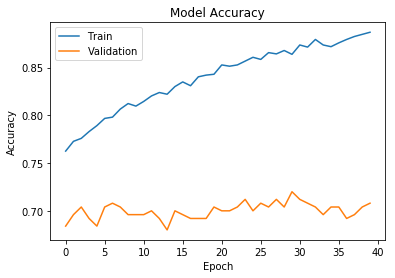

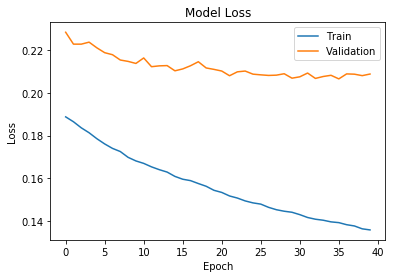

In [70]:
plt.plot(malstm_trained.history['acc'])
plt.plot(malstm_trained.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
X_test['left'] = pad_sequences(X_test['left'], maxlen=max_seq_length)
X_test['right'] = pad_sequences(X_test['right'], maxlen=max_seq_length)

# # Make sure everything is ok
assert X_test['left'].shape == X_test['right'].shape
assert len(X_test['left']) == len(Y_test)


In [71]:
score_malstm = malstm.evaluate([X_test['left'], X_test['right']], Y_test, batch_size=32, verbose=1, sample_weight=None)

670/670 [==============================] - 2s 3ms/step


In [72]:
score_malstm

[0.28888315158103828, 0.57761194034298857]

In [76]:
Y_pred = malstm.predict([X_test['left'], X_test['right']])


In [109]:
# probs = metrics.precision_recall_curve(Y_test)
# test_acc = metrics.auc()

prediction_metric = metrics.precision_score(Y_test, Y_pred_mapped)
recall_metric = metrics.recall_score(Y_test, Y_pred_mapped)
roc_metric = metrics.roc_auc_score(Y_test, Y_pred_mapped)

f1_metric = metrics.f1_score(Y_test, Y_pred_mapped)

In [87]:
Y_results = Y_pred

In [111]:
def give_class(x):
    return 1 if x>0.5 else 0
        

In [105]:
Y_pred_mapped = list(map(give_class, Y_pred))

In [110]:
print(prediction_metric, recall_metric, roc_metric, f1_metric)

0.666666666667 0.0878378378378 0.526539239775 0.155223880597
